<b>
<p>
<center>
<font size="5">
Crashes & Conditions: Predicting Accident Severity in the U.S. (2016–2023)
</font>
</center>
</p>

<p>
<center>
<font size="4">
Group 4
</font>
</center>
</p>
    
<p>
<center>
<font size="4">
Fyrooz Anika, Sunny, Tambudzai
</font>
</center>
</p>

<p>
<center>
<font size="3">
Data Science, Columbian College of Arts & Sciences, George Washington University

Course: Machine Learning I (DATS 6202 - Spring 2025)
</font>
</center>
</p>

<p>
<center>
<font size="3">
Instructor: Dr. Yuxiao (James) Huang  

Submission Date: April 28, 2025  
</font>
</center>
</p>
</b>

## **I. INTRODUCTION**

###  **Problem Statement**
Every year, millions of road accidents occur across the United States, causing tens of thousands of deaths and significant economic damage. According to the National Highway Traffic Safety Administration (NHTSA, 2025), **over 39,000 people die in traffic-related incidents annually**, while organizations such as the AAA Foundation for Traffic Safety estimate the economic cost of crashes at more than $870 billion per year due to emergency services, property damage, medical expenses, and traffic delays.

Among the many factors analyzed in traffic incident reports, **accident severity**, which measures the seriousness of an incident—is particularly important. It determines the scale of response required, the risk to life and infrastructure, and the long-term implications for policy and public safety planning. **Yet, in most real-world systems, severity is only recognized after the fact.**

This leads to a central question:  
> **Can we predict the severity of an accident in real-time using environmental, temporal, and infrastructural data?**

---

### **Motivation**

With the increasing availability of large-scale transportation data, **machine learning offers a powerful opportunity to detect patterns and anticipate high-risk conditions before accidents occur**. If we can identify combinations of features—such as weather conditions, road layout, and time of day—that are strongly linked to severe accidents, we can inform real-time decision-making in areas like:

- Emergency response deployment  
- Navigation safety alerts  
- Infrastructure planning and redesign  
- Smart city transportation systems  

Our project aligns with ongoing national efforts such as the Vision Zero initiative, which aims to eliminate all traffic-related deaths through data-driven strategies and proactive safety interventions.

---

### **Dataset Overview**

We use the [**US Accidents (2016–2023) dataset from Kaggle**](https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents/data) (Moosavi, 2023), which contains over 7.7 million records from February 2016 to March 2023 across the United States. Each record includes:

- **Location data**: city, state, latitude, and longitude  
- **Time-related data**: timestamp, day of week, duration  
- **Environmental data**: weather condition, temperature, visibility, wind speed  
- **Road context**: presence of junctions, crossings, traffic signals, and more  
- **Target label**: `Severity` (ranging from 1 to 4, with 4 being the most severe)

This real-world dataset allows us to train and evaluate predictive models in a context that closely mirrors the complexity of actual traffic environments.

---

###  **Objectives**

This project explores both analytical and predictive approaches to traffic accident severity, with the following objectives:

1. **Conduct exploratory data analysis (EDA)** to uncover patterns and correlations in accident severity.
2. **Train machine learning models**—specifically Shallow Neural Networks (SNN) and Deep Neural Networks (DNN)—to predict severity using environmental and contextual features.
3. **Simulate predictions** using the trained model to answer "what-if" questions, such as how severity changes under different weather or road conditions.

**Our goal is to tell a compelling machine learning story: one that begins with curiosity, deepens with statistical insight, and culminates in predictive power that can inform real-world safety interventions.**

## **II. NOTEBOOK SETUP & CONFIGURATION**

- This section installs required **packages**, mounts **Google Drive** for accessing datasets and **pretrained models**, and sets paths for project **utilities** and **output**. Sets up project **directories**, configures **TensorFlow** and **matplotlib**, and applies random seed settings to ensure **reproducibility** and visual **consistency**.


In [67]:
# Installing Required Packages
%pip install -q MissForest
%pip install -q tabtransformertf
%pip install -q optuna

#setting for offline or online
# 'colab' for Google Colab, 'local' for local machine for faster training
SETTING = 'local' # 'colab' or 'local'

# Mounting Google Drive and Setting Paths
import sys
import pickle as pkl
import warnings
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import numpy as np

# Mounting Google Drive
if SETTING == 'colab': 
    from google.colab import drive
    drive.mount('/content/drive')

    #Setting directory paths
    abspath_curr = '/content/drive/MyDrive/Colab Notebooks/ML_Final_Project/Data/'
    pretrained_model_path = '/content/drive/MyDrive/Colab Notebooks/ML_Final_Project/pretrained_model/'
    abspath_util_shallow = '/content/drive/MyDrive/Colab Notebooks/ML_Final_Project/utilities/p2_shallow_learning/'
    abspath_util_deep = '/content/drive/MyDrive/Colab Notebooks/ML_Final_Project/utilities/p3_deep_learning/'
    abspath_model_shallow = '/content/drive/MyDrive/Colab Notebooks/ML_Final_Project/models/p2_shallow_learning/'
else:
    path='/mnt/d/wls_data/Repos/Traffic/ML_Final_Project-20250424T235718Z-001/ML_Final_Project/'
    abspath_curr=path+'Data/'
    abspath_util_shallow=path+'utilities/p2_shallow_learning/'
    abspath_util_deep=path+'utilities/p3_deep_learning/'
    abspath_model_shallow=path+'models/p2_shallow_learning/'
    pretrained_model_path = path+'pretrained_model/'


# Suppressing warnings for cleaner output
warnings.filterwarnings("ignore")

# Matplotlib Configuration
%matplotlib inline
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)
plt.rc('figure', titlesize=20)


# TensorFlow GPU Configuration
if SETTING=='colab': 
    %tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

# Random Seed for Reproducibility
random_seed = 42
tf.random.set_seed(random_seed)
import numpy as np
np.random.seed(random_seed)

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## **III. DATA PREPROCESSING**

- In this section, we load the **already processed and pre-split datasets**(training, validation, and test sets) from Google Drive. These datasets were prepared in earlier steps and stored as `.parquet` files to preserve preprocessing work done outside this notebook.
- We retained only the relevant columns, and prepare them for cleaning and modeling. We also import shallow utility functions from the instructor-provided module to support model building later.



**Note**: There's **no need to split data again** — training, validation, and test sets are already defined.

**DATA LOADING**

In [68]:
# Setting working directory and import shallow utility functions
%cd $abspath_util_shallow
%run pmlm_utilities_shallow.ipynb

# Selecting columns to keep
columns_to_keep = [
    'ID', 'Severity', 'Start_Time', 'Start_Lat', 'Start_Lng',
    'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
    'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)',
    'Weather_Condition',
    'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit',
    'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming',
    'Traffic_Signal', 'Turning_Loop',
    'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight',
    'avg_severity','accident_count','accident_count_agg','avg_severity_agg'
]

# Loading datasets
import pandas as pd

df_raw_train = pd.read_parquet(abspath_curr + 'train_500k.parquet')
df_train = df_raw_train[columns_to_keep].copy(deep=True)

df_raw_val = pd.read_parquet(abspath_curr + 'val_100k.parquet')
df_val = df_raw_val[columns_to_keep].copy(deep=True)

df_raw_test = pd.read_parquet(abspath_curr + 'test_100k.parquet')
df_test = df_raw_test[columns_to_keep].copy(deep=True)

# Setting target column
target = 'Severity'

# Checking dimensions of each dataset
print("Training set:", df_train.shape)
print("Validation set:", df_val.shape)
print("Test set:", df_test.shape)

# Preview the first 5 rows from each dataset
print("\nTrain sample:")
display(df_train.head())

print("\nValidation sample:")
display(df_val.head())

print("\nTest sample:")
display(df_test.head())


/mnt/d/wls_data/Repos/Traffic/ML_Final_Project-20250424T235718Z-001/ML_Final_Project/utilities/p2_shallow_learning
Training set: (500000, 35)
Validation set: (100000, 35)
Test set: (100000, 35)

Train sample:


,ID,Severity,Start_Time,Start_Lat,Start_Lng,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),...,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,avg_severity,accident_count,accident_count_agg,avg_severity_agg
0,A-704344,3,2022-02-18 07:59:46,42.386353,-83.434624,11.0,1.0,70.0,29.38,10.0,...,False,False,Day,Day,Day,Day,2.250000,2.6,4.0,2.250000
1,A-2829962,3,2018-05-17 16:02:30,37.593452,-77.467453,75.9,NaN,82.0,29.97,10.0,...,False,False,Day,Day,Day,Day,2.750241,8.6,9.0,2.777778
2,A-5874660,2,2021-05-17 10:50:30,26.153265,-81.447283,82.0,82.0,52.0,30.09,10.0,...,False,False,Day,Day,Day,Day,2.500000,1.6,2.0,2.000000
3,A-5345075,2,2022-09-14 12:47:35,39.044819,-94.656151,86.0,86.0,40.0,29.25,10.0,...,False,False,Day,Day,Day,Day,2.050000,3.8,1.0,2.000000
4,A-7050682,4,2020-06-19 05:04:14,45.559810,-122.173270,55.0,55.0,83.0,29.95,10.0,...,False,False,Night,Day,Day,Day,3.200000,2.6,8.0,4.000000



Validation sample:


,ID,Severity,Start_Time,Start_Lat,Start_Lng,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),...,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,avg_severity,accident_count,accident_count_agg,avg_severity_agg
0,A-493786,2,2017-07-07 14:54:31,33.994232,-117.888687,91.0,NaN,33.0,29.83,10.0,...,False,False,Day,Day,Day,Day,2.033333,6.0,6.0,2.166667
1,A-2831063,2,2018-05-17 20:51:48,36.129860,-86.797638,70.0,NaN,90.0,29.86,10.0,...,False,False,Night,Night,Night,Day,2.416667,4.0,6.0,2.666667
2,A-5161972,2,2022-08-26 13:48:00,40.603680,-74.053461,87.0,87.0,49.0,29.86,10.0,...,False,False,Day,Day,Day,Day,2.042857,9.0,7.0,2.142857
3,A-284831,2,2016-09-15 17:30:58,32.780357,-97.071869,91.4,NaN,41.0,29.97,10.0,...,False,False,Day,Day,Day,Day,2.406667,3.2,5.0,2.200000
4,A-2995880,3,2018-02-07 08:42:30,36.813084,-76.281662,52.0,NaN,83.0,30.22,10.0,...,False,False,Day,Day,Day,Day,2.771111,5.4,9.0,2.555556



Test sample:


,ID,Severity,Start_Time,Start_Lat,Start_Lng,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),...,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,avg_severity,accident_count,accident_count_agg,avg_severity_agg
0,A-7456372,2,2019-01-02 12:11:03,46.043147,-123.913447,42.1,40.2,79.0,30.17,10.0,...,False,False,Day,Day,Day,Day,2.000000,1.0,NaN,NaN
1,A-1611395,2,2020-01-24 17:47:15,37.313671,-120.519272,55.0,55.0,86.0,29.95,6.0,...,False,False,Night,Night,Day,Day,2.000000,1.6,2.0,2.000000
2,A-6716454,2,2020-11-21 19:11:00,26.687072,-80.160808,78.0,78.0,66.0,30.09,10.0,...,False,False,Night,Night,Night,Night,2.200000,2.6,1.0,2.000000
3,A-976875,2,2021-07-07 08:08:40,36.102261,-86.765518,77.0,77.0,71.0,29.41,10.0,...,False,False,Day,Day,Day,Day,2.237607,12.2,13.0,2.076923
4,A-5497534,2,2021-07-29 14:29:48,42.995756,-77.367597,72.0,72.0,84.0,29.12,10.0,...,False,False,Day,Day,Day,Day,2.140000,2.0,NaN,NaN


**Dataset Preview & Observations**: After loading the training, validation, and test sets, we observed the following:

- Each dataset contained **35 columns** and had been filtered to include only the most relevant features, such as location coordinates, weather conditions, road attributes, and twilight indicators.
- The target variable `Severity` was present in all three datasets and ranged from **1 to 4**, consistent with the classification objective.
- Several weather-related columns, including `Wind_Chill(F)` and `Precipitation(in)`, included **missing values** that required further preprocessing.
- Boolean infrastructure features (e.g., `Traffic_Signal`, `Junction`, `Crossing`) were consistently encoded as **True/False**, allowing them to be directly used or encoded later.
- The `Start_Time` field was preserved in full datetime format, allowing us to later extract temporal features such as hour of day or day of week.
- Additional aggregated features such as `avg_severity`, `accident_count`, and their `_agg` variants were already computed and included in the dataset. These engineered features provided contextual depth that we later considered in our modeling pipeline.

**Note: At this stage, the datasets were cleanly structured and ready for exploratory analysis and preprocessing.**


**HANDLING UNCOMMON FEATURES ACROSS SPLITS**

- During preprocessing, we identified and removed features that were **inconsistently present** across the training, validation, and test datasets. This ensured that all datasets had the same feature space, which is essential for maintaining consistency during model training and evaluation.
- The function `common_var_checker` from our utility notebook was used to isolate features that were shared by all three datasets. We then dropped the features that existed only in one or two splits but not all, as they could introduce bias or result in errors downstream.

In [69]:
# Identifying and Removing Uncommon Features Across Datasets

# Finding features common to all splits (excluding target)
df_common_var = common_var_checker(df_train, df_val, df_test, target)
display(df_common_var)

# Identifying features that are unique to one dataset only
uncommon_feature_train_not_val_test = np.setdiff1d(df_train.columns, df_common_var['common var'])
uncommon_feature_val_not_train_test = np.setdiff1d(df_val.columns, df_common_var['common var'])
uncommon_feature_test_not_train_val = np.setdiff1d(df_test.columns, df_common_var['common var'])

# Displaying uncommon features for each set
print("\nUncommon in Training Only:")
display(pd.DataFrame(uncommon_feature_train_not_val_test, columns=['Uncommon Feature']))

print("\nUncommon in Validation Only:")
display(pd.DataFrame(uncommon_feature_val_not_train_test, columns=['Uncommon Feature']))

print("\nUncommon in Test Only:")
display(pd.DataFrame(uncommon_feature_test_not_train_val, columns=['Uncommon Feature']))

# Dropping uncommon features
df_train = df_train.drop(columns=uncommon_feature_train_not_val_test)
df_val = df_val.drop(columns=uncommon_feature_val_not_train_test)
df_test = df_test.drop(columns=uncommon_feature_test_not_train_val)

# Confirming dataset shapes and sample rows after cleanup
print("\nCleaned Training Set:")
display(df_train.head())

print("\nCleaned Validation Set:")
display(df_val.head())

print("\nCleaned Test Set:")
display(df_test.head())


,common var
0,Amenity
1,Astronomical_Twilight
2,Bump
3,Civil_Twilight
4,Crossing
5,Give_Way
6,Humidity(%)
7,ID
8,Junction
9,Nautical_Twilight



Uncommon in Training Only:


,Uncommon Feature



Uncommon in Validation Only:


,Uncommon Feature



Uncommon in Test Only:


,Uncommon Feature



Cleaned Training Set:


,ID,Severity,Start_Time,Start_Lat,Start_Lng,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),...,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,avg_severity,accident_count,accident_count_agg,avg_severity_agg
0,A-704344,3,2022-02-18 07:59:46,42.386353,-83.434624,11.0,1.0,70.0,29.38,10.0,...,False,False,Day,Day,Day,Day,2.250000,2.6,4.0,2.250000
1,A-2829962,3,2018-05-17 16:02:30,37.593452,-77.467453,75.9,NaN,82.0,29.97,10.0,...,False,False,Day,Day,Day,Day,2.750241,8.6,9.0,2.777778
2,A-5874660,2,2021-05-17 10:50:30,26.153265,-81.447283,82.0,82.0,52.0,30.09,10.0,...,False,False,Day,Day,Day,Day,2.500000,1.6,2.0,2.000000
3,A-5345075,2,2022-09-14 12:47:35,39.044819,-94.656151,86.0,86.0,40.0,29.25,10.0,...,False,False,Day,Day,Day,Day,2.050000,3.8,1.0,2.000000
4,A-7050682,4,2020-06-19 05:04:14,45.559810,-122.173270,55.0,55.0,83.0,29.95,10.0,...,False,False,Night,Day,Day,Day,3.200000,2.6,8.0,4.000000



Cleaned Validation Set:


,ID,Severity,Start_Time,Start_Lat,Start_Lng,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),...,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,avg_severity,accident_count,accident_count_agg,avg_severity_agg
0,A-493786,2,2017-07-07 14:54:31,33.994232,-117.888687,91.0,NaN,33.0,29.83,10.0,...,False,False,Day,Day,Day,Day,2.033333,6.0,6.0,2.166667
1,A-2831063,2,2018-05-17 20:51:48,36.129860,-86.797638,70.0,NaN,90.0,29.86,10.0,...,False,False,Night,Night,Night,Day,2.416667,4.0,6.0,2.666667
2,A-5161972,2,2022-08-26 13:48:00,40.603680,-74.053461,87.0,87.0,49.0,29.86,10.0,...,False,False,Day,Day,Day,Day,2.042857,9.0,7.0,2.142857
3,A-284831,2,2016-09-15 17:30:58,32.780357,-97.071869,91.4,NaN,41.0,29.97,10.0,...,False,False,Day,Day,Day,Day,2.406667,3.2,5.0,2.200000
4,A-2995880,3,2018-02-07 08:42:30,36.813084,-76.281662,52.0,NaN,83.0,30.22,10.0,...,False,False,Day,Day,Day,Day,2.771111,5.4,9.0,2.555556



Cleaned Test Set:


,ID,Severity,Start_Time,Start_Lat,Start_Lng,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),...,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,avg_severity,accident_count,accident_count_agg,avg_severity_agg
0,A-7456372,2,2019-01-02 12:11:03,46.043147,-123.913447,42.1,40.2,79.0,30.17,10.0,...,False,False,Day,Day,Day,Day,2.000000,1.0,NaN,NaN
1,A-1611395,2,2020-01-24 17:47:15,37.313671,-120.519272,55.0,55.0,86.0,29.95,6.0,...,False,False,Night,Night,Day,Day,2.000000,1.6,2.0,2.000000
2,A-6716454,2,2020-11-21 19:11:00,26.687072,-80.160808,78.0,78.0,66.0,30.09,10.0,...,False,False,Night,Night,Night,Night,2.200000,2.6,1.0,2.000000
3,A-976875,2,2021-07-07 08:08:40,36.102261,-86.765518,77.0,77.0,71.0,29.41,10.0,...,False,False,Day,Day,Day,Day,2.237607,12.2,13.0,2.076923
4,A-5497534,2,2021-07-29 14:29:48,42.995756,-77.367597,72.0,72.0,84.0,29.12,10.0,...,False,False,Day,Day,Day,Day,2.140000,2.0,NaN,NaN


**Observations on Uncommon Features Check**

The `common_var_checker` function returned **34 shared features** across all three datasets (training, validation, and test). These features form the consistent core that will be used for modeling.

We also verified that:
- There were **no uncommon features** present only in the training set.
- There were **no unique features** found in the validation set.
- There were **no unique features** found in the test set either.

This confirms that the datasets are already **well-aligned** in terms of schema, and no additional columns needed to be dropped at this stage. This ensures a smooth transition into encoding and feature engineering.


**HANDLING IDENTIFIERS**

- Identifiers such as `ID` or other row-specific attributes **are not predictive of the target variable and may introduce noise or leakage into the model**. In this step, we used the `id_checker` utility function to identify such columns and removed them from all dataset splits.
- This ensured that all remaining features were relevant for learning patterns, not merely identifying rows.


In [70]:
# Identifying and Removing Row-Level Identifiers

# Combining all datasets temporarily
df = pd.concat([df_train, df_val, df_test], sort=False)

# Identifying ID-like features using utility function
df_id = id_checker(df)
display(df_id.head())  # Preview detected identifier columns

# Dropping ID columns from each dataset if present
import numpy as np

id_columns = np.intersect1d(df_id.columns, df_train.columns)
df_train.drop(columns=id_columns, inplace=True)
df_val.drop(columns=id_columns, inplace=True)
df_test.drop(columns=id_columns, inplace=True)

# Previewing the cleaned datasets
print("\nTraining Set After ID Removal:")
display(df_train.head())

print("\nValidation Set After ID Removal:")
display(df_val.head())

print("\nTest Set After ID Removal:")
display(df_test.head())


,ID
0,A-704344
1,A-2829962
2,A-5874660
3,A-5345075
4,A-7050682



Training Set After ID Removal:


,Severity,Start_Time,Start_Lat,Start_Lng,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,...,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,avg_severity,accident_count,accident_count_agg,avg_severity_agg
0,3,2022-02-18 07:59:46,42.386353,-83.434624,11.0,1.0,70.0,29.38,10.0,WNW,...,False,False,Day,Day,Day,Day,2.250000,2.6,4.0,2.250000
1,3,2018-05-17 16:02:30,37.593452,-77.467453,75.9,NaN,82.0,29.97,10.0,Variable,...,False,False,Day,Day,Day,Day,2.750241,8.6,9.0,2.777778
2,2,2021-05-17 10:50:30,26.153265,-81.447283,82.0,82.0,52.0,30.09,10.0,E,...,False,False,Day,Day,Day,Day,2.500000,1.6,2.0,2.000000
3,2,2022-09-14 12:47:35,39.044819,-94.656151,86.0,86.0,40.0,29.25,10.0,SSW,...,False,False,Day,Day,Day,Day,2.050000,3.8,1.0,2.000000
4,4,2020-06-19 05:04:14,45.559810,-122.173270,55.0,55.0,83.0,29.95,10.0,E,...,False,False,Night,Day,Day,Day,3.200000,2.6,8.0,4.000000



Validation Set After ID Removal:


,Severity,Start_Time,Start_Lat,Start_Lng,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,...,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,avg_severity,accident_count,accident_count_agg,avg_severity_agg
0,2,2017-07-07 14:54:31,33.994232,-117.888687,91.0,NaN,33.0,29.83,10.0,Variable,...,False,False,Day,Day,Day,Day,2.033333,6.0,6.0,2.166667
1,2,2018-05-17 20:51:48,36.129860,-86.797638,70.0,NaN,90.0,29.86,10.0,NNW,...,False,False,Night,Night,Night,Day,2.416667,4.0,6.0,2.666667
2,2,2022-08-26 13:48:00,40.603680,-74.053461,87.0,87.0,49.0,29.86,10.0,S,...,False,False,Day,Day,Day,Day,2.042857,9.0,7.0,2.142857
3,2,2016-09-15 17:30:58,32.780357,-97.071869,91.4,NaN,41.0,29.97,10.0,SE,...,False,False,Day,Day,Day,Day,2.406667,3.2,5.0,2.200000
4,3,2018-02-07 08:42:30,36.813084,-76.281662,52.0,NaN,83.0,30.22,10.0,SSE,...,False,False,Day,Day,Day,Day,2.771111,5.4,9.0,2.555556



Test Set After ID Removal:


,Severity,Start_Time,Start_Lat,Start_Lng,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,...,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,avg_severity,accident_count,accident_count_agg,avg_severity_agg
0,2,2019-01-02 12:11:03,46.043147,-123.913447,42.1,40.2,79.0,30.17,10.0,ESE,...,False,False,Day,Day,Day,Day,2.000000,1.0,NaN,NaN
1,2,2020-01-24 17:47:15,37.313671,-120.519272,55.0,55.0,86.0,29.95,6.0,SE,...,False,False,Night,Night,Day,Day,2.000000,1.6,2.0,2.000000
2,2,2020-11-21 19:11:00,26.687072,-80.160808,78.0,78.0,66.0,30.09,10.0,ENE,...,False,False,Night,Night,Night,Night,2.200000,2.6,1.0,2.000000
3,2,2021-07-07 08:08:40,36.102261,-86.765518,77.0,77.0,71.0,29.41,10.0,S,...,False,False,Day,Day,Day,Day,2.237607,12.2,13.0,2.076923
4,2,2021-07-29 14:29:48,42.995756,-77.367597,72.0,72.0,84.0,29.12,10.0,WSW,...,False,False,Day,Day,Day,Day,2.140000,2.0,NaN,NaN


**Observations on Identifier Removal**

Following the execution of the `id_checker` function, we identified and removed non-predictive row-level identifiers from all dataset splits. As shown in the preview:

- The `ID` column (previously present) was successfully removed.
- The dataset structure remained consistent across **training**, **validation**, and **test** sets, each now containing **34 columns**.
- All retained features are descriptive or contextual variables that can contribute meaningfully to model training.
- No essential features were lost in the process, and the datasets remain aligned for further preprocessing.

This step helps prevent any accidental overfitting or data leakage that could arise from using identifiers as inputs.


**HANDLING DATE-TIME VARIABLES**

- Temporal features such as hour of day, day of week, and month can significantly influence accident severity due to patterns in commuting, visibility, and traffic volume.

- In this step, we applied the `datetime_transformer` utility to extract time-related features from the `Start_Time` column. The transformation was applied consistently to the **training**, **validation**, and **test** datasets, using a helper column `time_bin` to isolate the datetime parsing.

These new features will help the model learn time-based trends that may affect accident severity.



In [71]:
# Transforming datetime variables in training, validation, and test sets

# Defining the list of datetime transformation targets
datetime_vars = ['time_bin']

# TRAINING SET
df_train['time_bin'] = pd.to_datetime(df_train['Start_Time'], format='mixed')
df_train = datetime_transformer(df_train, datetime_vars)
print("Training set after datetime transformation:")
display(df_train.head())

# VALIDATION SET
df_val['time_bin'] = pd.to_datetime(df_val['Start_Time'], format='mixed')
df_val = datetime_transformer(df_val, datetime_vars)
print("Validation set after datetime transformation:")
display(df_val.head())

# TEST SET
df_test['time_bin'] = pd.to_datetime(df_test['Start_Time'], format='mixed')
df_test = datetime_transformer(df_test, datetime_vars)
print("Test set after datetime transformation:")
display(df_test.head())


Training set after datetime transformation:


,Severity,Start_Time,Start_Lat,Start_Lng,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,...,avg_severity,accident_count,accident_count_agg,avg_severity_agg,time_bin_year,time_bin_month,time_bin_day,time_bin_hour,time_bin_minute,time_bin_second
0,3,2022-02-18 07:59:46,42.386353,-83.434624,11.0,1.0,70.0,29.38,10.0,WNW,...,2.250000,2.6,4.0,2.250000,2022,2,18,7,59,46
1,3,2018-05-17 16:02:30,37.593452,-77.467453,75.9,NaN,82.0,29.97,10.0,Variable,...,2.750241,8.6,9.0,2.777778,2018,5,17,16,2,30
2,2,2021-05-17 10:50:30,26.153265,-81.447283,82.0,82.0,52.0,30.09,10.0,E,...,2.500000,1.6,2.0,2.000000,2021,5,17,10,50,30
3,2,2022-09-14 12:47:35,39.044819,-94.656151,86.0,86.0,40.0,29.25,10.0,SSW,...,2.050000,3.8,1.0,2.000000,2022,9,14,12,47,35
4,4,2020-06-19 05:04:14,45.559810,-122.173270,55.0,55.0,83.0,29.95,10.0,E,...,3.200000,2.6,8.0,4.000000,2020,6,19,5,4,14


Validation set after datetime transformation:


,Severity,Start_Time,Start_Lat,Start_Lng,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,...,avg_severity,accident_count,accident_count_agg,avg_severity_agg,time_bin_year,time_bin_month,time_bin_day,time_bin_hour,time_bin_minute,time_bin_second
0,2,2017-07-07 14:54:31,33.994232,-117.888687,91.0,NaN,33.0,29.83,10.0,Variable,...,2.033333,6.0,6.0,2.166667,2017,7,7,14,54,31
1,2,2018-05-17 20:51:48,36.129860,-86.797638,70.0,NaN,90.0,29.86,10.0,NNW,...,2.416667,4.0,6.0,2.666667,2018,5,17,20,51,48
2,2,2022-08-26 13:48:00,40.603680,-74.053461,87.0,87.0,49.0,29.86,10.0,S,...,2.042857,9.0,7.0,2.142857,2022,8,26,13,48,0
3,2,2016-09-15 17:30:58,32.780357,-97.071869,91.4,NaN,41.0,29.97,10.0,SE,...,2.406667,3.2,5.0,2.200000,2016,9,15,17,30,58
4,3,2018-02-07 08:42:30,36.813084,-76.281662,52.0,NaN,83.0,30.22,10.0,SSE,...,2.771111,5.4,9.0,2.555556,2018,2,7,8,42,30


Test set after datetime transformation:


,Severity,Start_Time,Start_Lat,Start_Lng,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,...,avg_severity,accident_count,accident_count_agg,avg_severity_agg,time_bin_year,time_bin_month,time_bin_day,time_bin_hour,time_bin_minute,time_bin_second
0,2,2019-01-02 12:11:03,46.043147,-123.913447,42.1,40.2,79.0,30.17,10.0,ESE,...,2.000000,1.0,NaN,NaN,2019,1,2,12,11,3
1,2,2020-01-24 17:47:15,37.313671,-120.519272,55.0,55.0,86.0,29.95,6.0,SE,...,2.000000,1.6,2.0,2.000000,2020,1,24,17,47,15
2,2,2020-11-21 19:11:00,26.687072,-80.160808,78.0,78.0,66.0,30.09,10.0,ENE,...,2.200000,2.6,1.0,2.000000,2020,11,21,19,11,0
3,2,2021-07-07 08:08:40,36.102261,-86.765518,77.0,77.0,71.0,29.41,10.0,S,...,2.237607,12.2,13.0,2.076923,2021,7,7,8,8,40
4,2,2021-07-29 14:29:48,42.995756,-77.367597,72.0,72.0,84.0,29.12,10.0,WSW,...,2.140000,2.0,NaN,NaN,2021,7,29,14,29,48


**Observations on Date-Time Feature Extraction**

As shown in the output, the `datetime_transformer` function created multiple time-based features derived from the `Start_Time` column. These include:

- `time_bin_year`, `time_bin_month`, `time_bin_day`: capturing long-term and seasonal trends
- `time_bin_hour`, `time_bin_minute`, `time_bin_second`: capturing fine-grained temporal patterns (e.g., rush hour effects)

The transformation was applied consistently across all splits (train, validation, test), and no NaN values or formatting issues were introduced in the process.

These new temporal features provide valuable information that will help the model detect patterns related to **time-of-day severity**, **weekday vs weekend risk**, or **seasonal traffic variations**.


**HANDLING MISSING DATA**

- To assess the presence and distribution of missing values in the dataset, we first combined all three splits (training, validation, and test). We used the `nan_checker` utility function to identify variables with missing values, their data types, and the proportion of missing entries.
- This step is essential to guide our imputation strategy later. After identifying missingness, we carefully separated the combined dataset back into its original splits while preserving structural integrity.





In [72]:
# Combining datasets to assess missing values globally
df = pd.concat([df_train, df_val, df_test], sort=False)

# Checking for missing values using utility
df_nan = nan_checker(df)
display(df_nan)

# Printing unique data types of features with missing values
pd.DataFrame(df_nan['dtype'].unique(), columns=['dtype'])

# Focussing on numeric columns with missing data
df_miss = df_nan[df_nan['dtype'] == 'float64'].reset_index(drop=True)
display(df_miss)

# Separating combined dataset back into train, val, test
df_train = df.iloc[:df_train.shape[0], :].copy()
df_val = df.iloc[df_train.shape[0]:df_train.shape[0] + df_val.shape[0], :].copy()
df_test = df.iloc[df_train.shape[0] + df_val.shape[0]:, :].copy()

# Confirm singhape consistency after split
print("Dataset Dimensions After Re-separation:")
display(pd.DataFrame([[df_train.shape[0], df_train.shape[1]]], columns=['# rows', '# columns'], index=['Train']))
display(pd.DataFrame([[df_val.shape[0], df_val.shape[1]]], columns=['# rows', '# columns'], index=['Validation']))
display(pd.DataFrame([[df_test.shape[0], df_test.shape[1]]], columns=['# rows', '# columns'], index=['Test']))


,var,proportion,dtype
0,Precipitation(in),0.285583,float64
1,Wind_Chill(F),0.259070,float64
2,Wind_Speed(mph),0.074080,float64
3,avg_severity_agg,0.066536,float64
4,accident_count_agg,0.066536,float64
5,Visibility(mi),0.023043,float64
6,Wind_Direction,0.022739,object
7,Humidity(%),0.022691,float64
8,Weather_Condition,0.022527,object
9,Temperature(F),0.021337,float64


,var,proportion,dtype
0,Precipitation(in),0.285583,float64
1,Wind_Chill(F),0.259070,float64
2,Wind_Speed(mph),0.074080,float64
3,avg_severity_agg,0.066536,float64
4,accident_count_agg,0.066536,float64
5,Visibility(mi),0.023043,float64
6,Humidity(%),0.022691,float64
7,Temperature(F),0.021337,float64
8,Pressure(in),0.018321,float64


Dataset Dimensions After Re-separation:


,# rows,# columns
Train,500000,40


,# rows,# columns
Validation,100000,40


,# rows,# columns
Test,100000,40


**Observations on Missing Data**

Using the `nan_checker` utility, we identified a total of **15 features** across the dataset that contain missing values. These include both numerical (`float64`) and categorical (`object`) variables.

Key findings:
- The **highest proportion of missing data** was observed in `Precipitation(in)` (28.6%) and `Wind_Chill(F)` (25.9%), followed by `Wind_Speed(mph)` (7.4%).
- Other weather-related features such as `Temperature(F)`, `Humidity(%)`, `Pressure(in)`, and `Visibility(mi)` also had minor proportions of missingness, ranging from ~1.8% to ~2.3%.
- Several engineered features (`avg_severity_agg`, `accident_count_agg`) showed missingness around 6.6%.
- Categorical object-type variables (e.g., `Weather_Condition`, `Civil_Twilight`, `Sunrise_Sunset`) had minimal missingness (~0.2%).

We confirmed that after recombining and re-splitting the data, the **training (500,000 rows), validation (100,000 rows), and test (100,000 rows)** datasets each retained the expected shape and column count (40 columns). These findings will guide our imputation strategies in the next step.


**IMPUTING MISSING VALUES**

We used the **MissForest** algorithm to impute missing values across the training, validation, and test sets.MissForest is an iterative, non-parametric imputation method based on Random Forests. It is particularly effective when:
- Data is mixed-type (numerical + categorical)
- Missingness is not completely at random
- Imputation must preserve nonlinear relationships

In our pipeline, we trained the MissForest model **only on the training set** and used it to impute missing values for all splits.

**Note: This imputation step was performed after encoding categorical variables, since MissForest requires purely numerical inputs**.

**ENCODING CATEGORICAL VARIABLES &FEATURE CLEANUP**

Before imputation, all categorical features must be encoded numerically. We applied the following transformations:

- Cleaned and canonicalized `Weather_Condition` into non-exclusive binary categories and Mapped `Wind_Direction` into standardized compass directions.
- Removed non-useful or redundant columns and One-hot encoded categorical variables using `pd.get_dummies`.
- Applied `LabelEncoder` to the target variable `Severity` and Cast all boolean columns as integers.


In [73]:
# Combine datasets for unified encoding
df = pd.concat([df_train, df_val, df_test], sort=False)

# Inspect data types
pd.DataFrame(df.dtypes.unique(), columns=['dtype'])

# Identify categorical variables
df_cat = cat_var_checker(df)
display(df_cat)

# Drop unnecessary columns
df.drop(columns=['Start_Time', 'time_bin_minute', 'time_bin_second', 'Start_Lat', 'Start_Lng'], inplace=True)

# Canonicalize Weather_Condition into binary flags
weather_categories = {
    'Clear': ['clear', 'fair'],
    'Cloudy': ['cloudy', 'overcast'],
    'Rain': ['rain', 'drizzle'],
    'Drizzle': ['drizzle'],
    'Snow': ['snow'],
    'Sleet/Ice': ['sleet', 'ice', 'pellets'],
    'Thunderstorm': ['thunder', 't-storm', 'tstorm'],
    'Hail': ['hail'],
    'Fog': ['fog', 'mist'],
    'Windy': ['wind', 'blow', 'squall'],
    'Particulate': ['dust', 'sand', 'ash'],
    'Severe': ['tornado', 'funnel']
}
df['lc'] = df['Weather_Condition'].fillna('').str.lower()
for cat, keys in weather_categories.items():
    df[cat] = df['lc'].apply(lambda s: int(any(k in s for k in keys)))
    df.loc[df['lc'] == '', cat] = np.nan
df.drop(columns=['Weather_Condition', 'lc', 'Clear'], inplace=True)

# Canonicalize Wind_Direction
wind_dir_map = {
    'CALM': 'Calm', 'Calm': 'Calm', 'VAR': 'Variable', 'Variable': 'Variable',
    'N': 'N', 'North': 'N', 'NNE': 'NNE', 'NNW': 'NNW',
    'NE': 'NE', 'ENE': 'ENE', 'E': 'E', 'East': 'E', 'ESE': 'ESE',
    'SE': 'SE', 'SSE': 'SSE', 'S': 'S', 'South': 'S', 'SSW': 'SSW',
    'SW': 'SW', 'WSW': 'WSW', 'W': 'W', 'West': 'W', 'WNW': 'WNW', 'NW': 'NW'
}
df['Wind_Direction'] = df['Wind_Direction'].map(wind_dir_map)

# One-hot encode selected categorical variables
df = pd.get_dummies(df, columns=np.setdiff1d(np.intersect1d(df.columns, df_cat['var'].tolist() + ['time_bin_day', 'time_bin_hour', 'time_bin_month', 'time_bin_year']), [target]), drop_first=True)

# Label encode target
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df[target] = le.fit_transform(df[target].astype(str))

# Convert bools to integers
for col in df.columns:
    if df[col].dtype == 'bool':
        df[col] = df[col].astype(int)

# Re-separate datasets
df_train = df.iloc[:df_train.shape[0], :].copy()
df_val = df.iloc[df_train.shape[0]:df_train.shape[0] + df_val.shape[0], :].copy()
df_test = df.iloc[df_train.shape[0] + df_val.shape[0]:, :].copy()

# Confirm shape
display(pd.DataFrame([[df_train.shape[0], df_train.shape[1]]], columns=['# rows', '# columns'], index=['Train']))
display(pd.DataFrame([[df_val.shape[0], df_val.shape[1]]], columns=['# rows', '# columns'], index=['Validation']))
display(pd.DataFrame([[df_test.shape[0], df_test.shape[1]]], columns=['# rows', '# columns'], index=['Test']))


,var,nunique
0,Start_Time,675841
1,Weather_Condition,120
2,Wind_Direction,25
3,Sunrise_Sunset,3
4,Civil_Twilight,3
5,Nautical_Twilight,3
6,Astronomical_Twilight,3


,# rows,# columns
Train,500000,128


,# rows,# columns
Validation,100000,128


,# rows,# columns
Test,100000,128


**IMPUTING MISSING VALUES WITH MISSFOREST**

Once categorical variables were encoded, we used the **MissForest** algorithm to impute missing values in the dataset.

- The model was trained on the training set only
- Pretrained MissForest objects were reused if available
- Missing values in validation and test sets were imputed using the trained model


In [74]:
from missforest import MissForest

# Define categorical columns (already one-hot encoded or binary)
cat_cols = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
            'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Cloudy', 'Rain', 'Drizzle', 'Snow', 'Sleet/Ice',
            'Thunderstorm', 'Hail', 'Fog', 'Windy', 'Particulate', 'Severe', 'Astronomical_Twilight_Night',
            'Civil_Twilight_Night', 'Nautical_Twilight_Night', 'Sunrise_Sunset_Night', 'Wind_Direction_E',
            'Wind_Direction_ENE', 'Wind_Direction_ESE', 'Wind_Direction_N', 'Wind_Direction_NE', 'Wind_Direction_NNE',
            'Wind_Direction_NNW', 'Wind_Direction_NW', 'Wind_Direction_S', 'Wind_Direction_SE', 'Wind_Direction_SSE',
            'Wind_Direction_SSW', 'Wind_Direction_SW', 'Wind_Direction_Variable', 'Wind_Direction_W',
            'Wind_Direction_WNW', 'Wind_Direction_WSW']

# Load or fit MissForest
if os.path.exists(pretrained_model_path + 'miss_forest.pkl'):
    mf = pkl.load(open(pretrained_model_path + 'miss_forest.pkl', 'rb'))
    train_imputed = mf.transform(df_train.drop(columns=[target]))
else:
    mf = MissForest(categorical=cat_cols)
    train_imputed = mf.fit_transform(df_train.drop(columns=[target]))
    pkl.dump(mf, open(pretrained_model_path + 'miss_forest.pkl', 'wb'))

# Reattach target
train_imputed['Severity'] = df_train[target].values

# Impute validation and test
val_imputed = mf.transform(df_val.drop(columns=[target]))
val_imputed['Severity'] = df_val[target].values

test_imputed = mf.transform(df_test.drop(columns=[target]))
test_imputed['Severity'] = df_test[target].values


 40%|████      | 2/5 [00:01<00:02,  1.45it/s]


**Observations on MissForest Imputation**

The **MissForest** imputation process was successfully executed. Key outcomes:

- The algorithm trained on the **training set only**, ensuring no data leakage from validation or test data.
- Missing values were imputed for all three datasets using either:
  - a **pretrained model** loaded from disk, or
  - a **newly trained model** (when no cache file was found).
- The imputation progress bar confirms that multiple iterations were used, refining estimates in each pass.
- After imputation, the `Severity` column (target) was reattached to each dataset.


**FINAL PREPROCESSING - FEATURE/TARGET SPLIT AND STANDARDIZATION**

Before training models, we completed the final preprocessing steps:

- Separated the feature matrices `X_train`, `X_val`, and `X_test` from their corresponding target vectors.
- Standardized all numeric features using `StandardScaler` to ensure uniform scaling across inputs.
- This step ensures our models are not biased by differing units or magnitudes across features.

In [75]:
# Splitting feature matrix (X) and target vector (y)
columns_order=np.setdiff1d(train_imputed.columns, [target])
X_train = train_imputed[np.setdiff1d(train_imputed.columns, [target])].values
X_val = val_imputed[np.setdiff1d(val_imputed.columns, [target])].values
X_test = test_imputed[np.setdiff1d(test_imputed.columns, [target])].values

y_train = train_imputed[target].values
y_val = val_imputed[target].values
y_test = test_imputed[target].values

# Preparing for standardization
df = None
df_train = None
df_val = None
df_test = None

from sklearn.preprocessing import StandardScaler

# Defining feature groups
CATEGORICAL_FEATURES = cat_cols + ['time_bin_day', 'time_bin_hour', 'time_bin_month', 'time_bin_year']
NUMERIC_FEATURES1 = np.setdiff1d(train_imputed.columns.to_list(), [target] + CATEGORICAL_FEATURES).tolist()
FEATURES = CATEGORICAL_FEATURES + NUMERIC_FEATURES1
LABEL = target

# # Standardizing numeric features
ss = StandardScaler()
train_imputed[NUMERIC_FEATURES1] = ss.fit_transform(train_imputed[NUMERIC_FEATURES1])
val_imputed[NUMERIC_FEATURES1] = ss.transform(val_imputed[NUMERIC_FEATURES1])
test_imputed[NUMERIC_FEATURES1] = ss.transform(test_imputed[NUMERIC_FEATURES1])


## **IV. EXPLORATORY DATA ANALYSIS (RAW EDA)**

Before diving into modeling, we conducted an exploratory analysis of the **raw, observed data** to **uncover early patterns**, **spark curiosity**, and **ask questions** that our models might later answer.

This phase was **purely observational** — no modeling wass involved. Our goal here was to:
- Understand relationships between features and accident severity
- Identify potential patterns or anomalies
- Generate hypotheses for model-driven testing later

> For example: If accidents during foggy weather appear more severe, can our trained model later confirm and simulate that? Each of the following subsections explores a different real-world question inspired by the dataset.




### **EDA Question 1: When Do Accidents Happen Most Often?**

Beyond severity, understanding **when accidents occur most frequently** is critical for public safety planning and resource allocation. For instance, a higher number of accidents in certain months or years may signal broader traffic patterns, policy gaps, or seasonal risks.

To explore this, we visualized:
- The **total number of accidents per year**, to assess growth or decline in incidents over time.
- The **distribution of accidents across months**, to reveal any **seasonal trends** or spikes.

These insights helped contextualize our modeling work and inspired ideas for simulating accident risk across time-based scenarios.


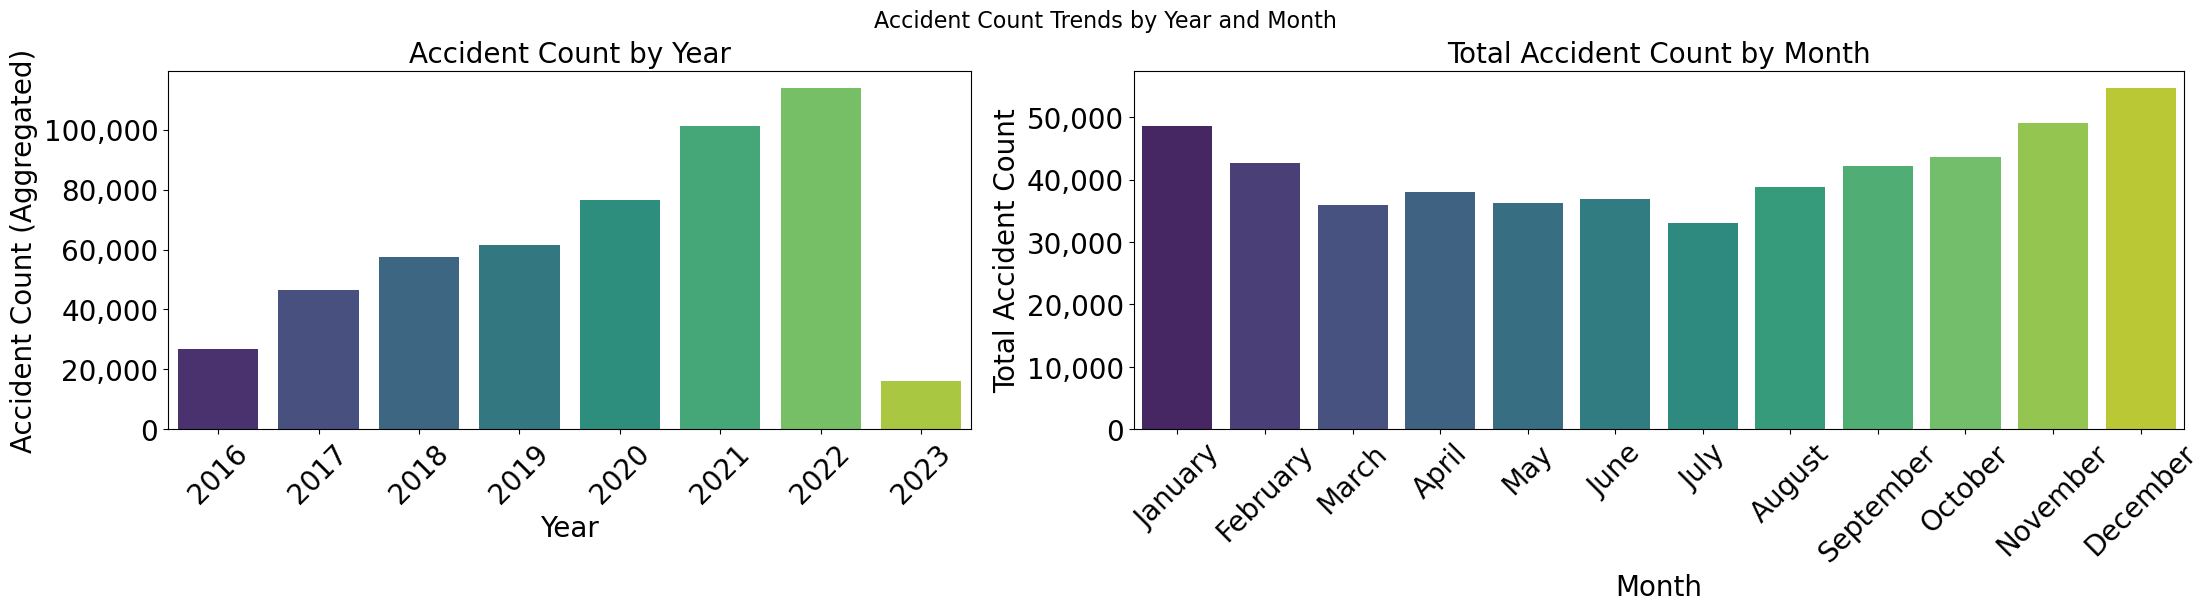

In [10]:
# Restore df_train
df_train = train_imputed.copy()

# Restore Start_Time from raw (for datetime feature extraction)
df_train['Start_Time'] = df_raw_train['Start_Time'].reset_index(drop=True)

# Recreate time_bin and extract date parts
df_train['time_bin'] = pd.to_datetime(df_train['Start_Time'], format='mixed')
df_train = datetime_transformer(df_train, ['time_bin'])

# Reattach accident count from raw


import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import pandas as pd

# === Yearly Aggregation ===
time_year_agg = df_train.groupby('time_bin_year').size().reset_index(name='accident_count_agg')

# === Monthly Aggregation ===
month_accidents = df_train.groupby('time_bin_month').size().reset_index(name='accident_count_agg')
month_order = list(range(1, 13))
month_accidents['time_bin_month'] = pd.Categorical(month_accidents['time_bin_month'], categories=month_order, ordered=True)
month_accidents = month_accidents.sort_values('accident_count_agg', ascending=False)
month_names = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
    7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'
}
month_accidents['Month'] = month_accidents['time_bin_month'].map(month_names)

# === Custom Width Handling ===
formatter = FuncFormatter(lambda x, _: f'{x:,.0f}')
fig = plt.figure(constrained_layout=True, figsize=(22, 6))
gs = fig.add_gridspec(1, 2, width_ratios=[1.3, 1.7])
fig.suptitle("Accident Count Trends by Year and Month", fontsize=16)

# Plot 1: By Year
ax1 = fig.add_subplot(gs[0, 0])
sns.barplot(ax=ax1, data=time_year_agg, x='time_bin_year', y='accident_count_agg', palette='viridis')
ax1.set_title("Accident Count by Year")
ax1.set_xlabel("Year")
ax1.set_ylabel("Accident Count (Aggregated)")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax1.yaxis.set_major_formatter(formatter)

# Plot 2: By Month
ax2 = fig.add_subplot(gs[0, 1])
sns.barplot(ax=ax2, data=month_accidents, x='Month', y='accident_count_agg', palette='viridis')
ax2.set_title("Total Accident Count by Month")
ax2.set_xlabel("Month")
ax2.set_ylabel("Total Accident Count")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
ax2.yaxis.set_major_formatter(formatter)

plt.show()


The bar charts reveal two key temporal trends:

- **Accidents increased sharply over time**, with a notable rise between 2020 and 2022. This may reflect improvements in data reporting, traffic growth, or external factors like changing commute patterns during and after the pandemic.
- **Seasonal variation is evident**, with **December, November, and October** showing the highest accident counts. This may be attributed to holiday travel, winter weather, or reduced daylight hours during those months.

These insights provide useful temporal context and supported our decision to include `year` and `month` features in the modeling pipeline.


### **EDA Question 2/: Are Accidents More Severe in Bad Weather?:**

We began our exploration with a simple, real-world question:  
> **Do weather conditions influence the severity of road accidents?**

Intuitively, fog, heavy rain, or snow could impair visibility and road grip — potentially leading to more serious incidents. To investigate this, we examined how severity varies across different weather types in the **raw dataset.**


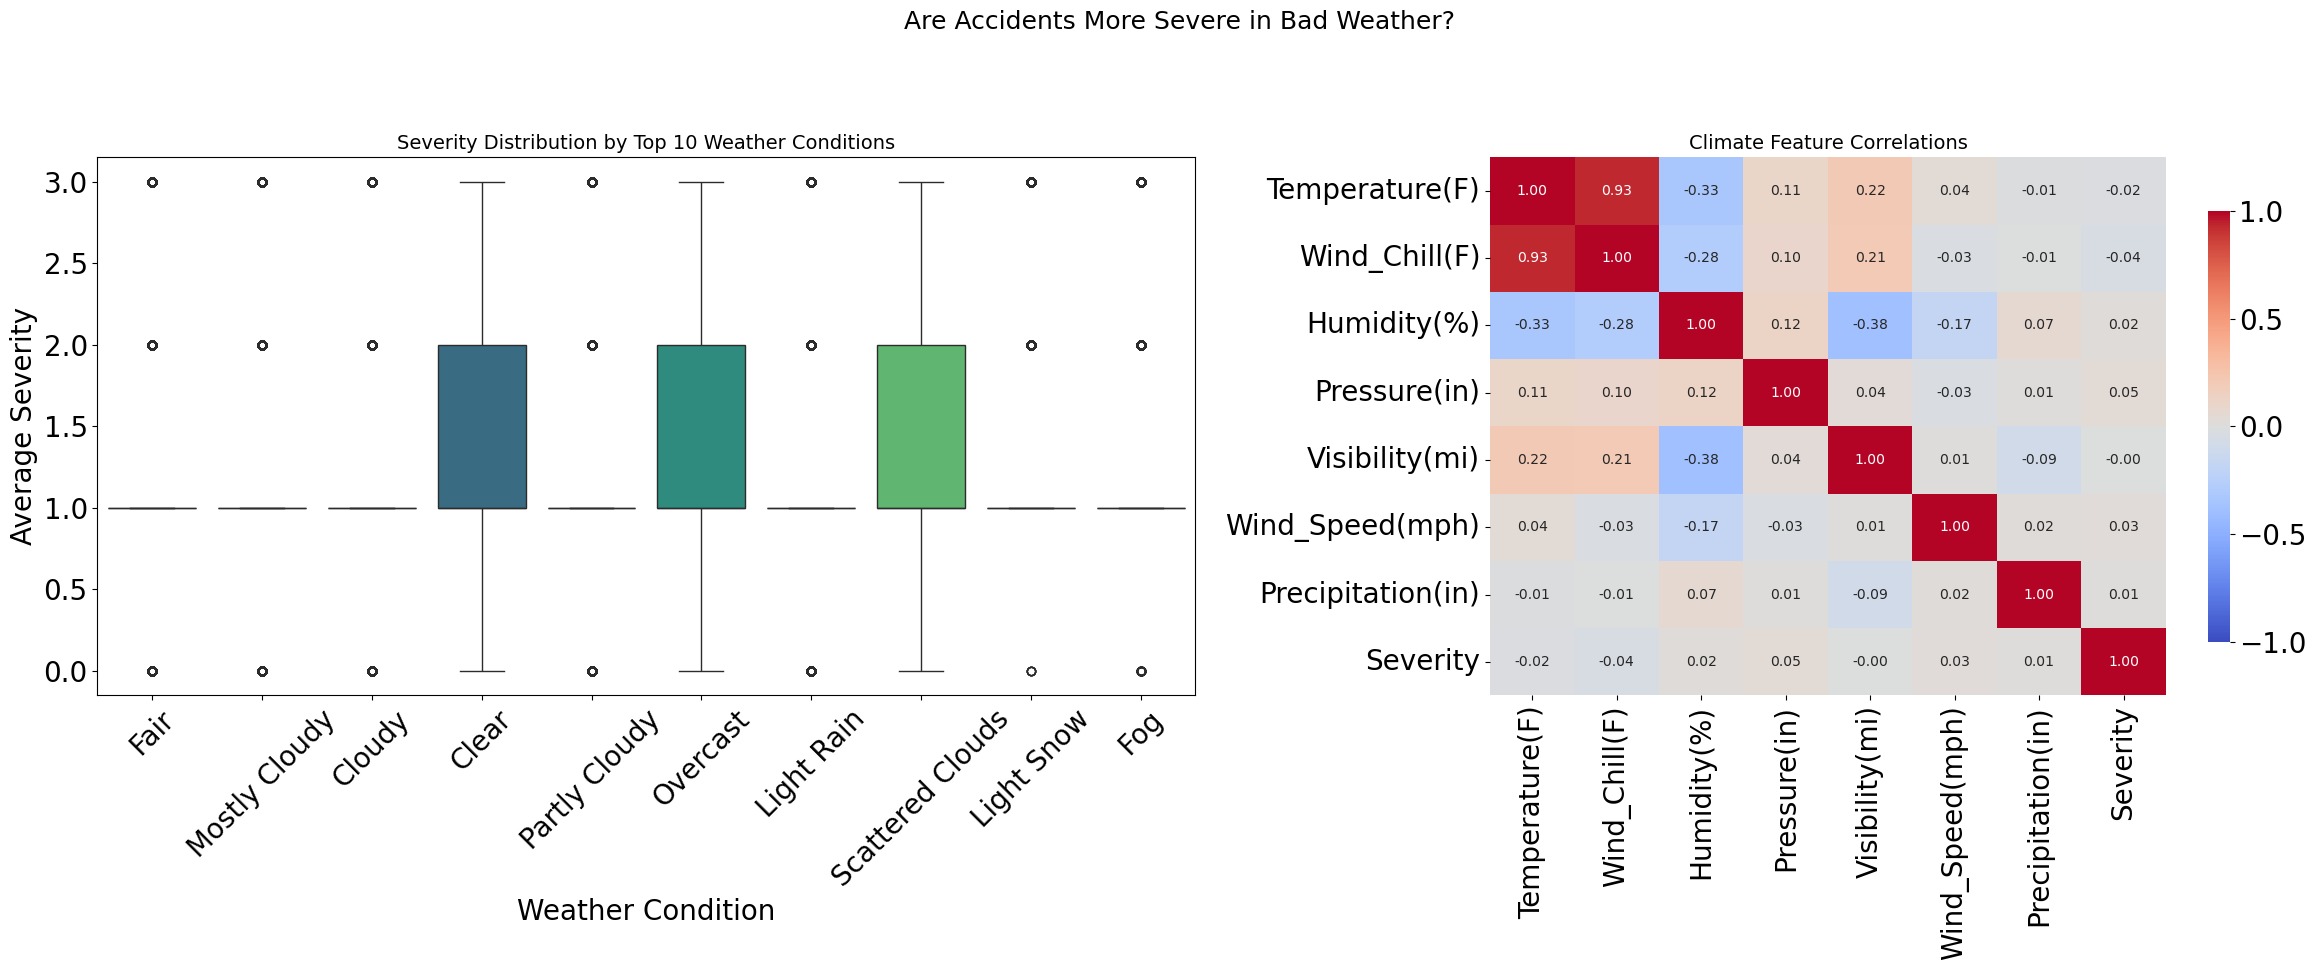

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Restore 'Weather_Condition' from raw data (if missing)
if 'Weather_Condition' not in df_train.columns:
    df_train['Weather_Condition'] = df_raw_train['Weather_Condition'].reset_index(drop=True)

# === BOX PLOT SETUP ===
weather_counts = df_train['Weather_Condition'].value_counts().reset_index()
weather_counts.columns = ['Weather_Condition', 'Count']
top_weather_conditions = weather_counts.head(10)['Weather_Condition'].tolist()
df_top_weather = df_train[df_train['Weather_Condition'].isin(top_weather_conditions)].copy()

df_top_weather['Weather_Condition'] = pd.Categorical(
    df_top_weather['Weather_Condition'],
    categories=top_weather_conditions,
    ordered=True
)

# === CORRELATION HEATMAP SETUP ===
climate_columns = ['Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
                   'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 'Severity']
climate_data = df_train[climate_columns].copy()
correlation_matrix = climate_data.corr()

# === COMBINED PLOT with Correct Height & Alignment ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10), gridspec_kw={'width_ratios': [1.3, 1]})
fig.suptitle("Are Accidents More Severe in Bad Weather?", fontsize=18)

# Boxplot (fixed alignment)
sns.boxplot(
    ax=ax1,
    data=df_top_weather,
    x='Weather_Condition',
    y='Severity',
    palette='viridis'
)
ax1.set_title("Severity Distribution by Top 10 Weather Conditions", fontsize=14)
ax1.set_xlabel("Weather Condition")
ax1.set_ylabel("Average Severity")
ax1.tick_params(axis='x', rotation=45)

# Heatmap
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    vmin=-1, vmax=1,
    ax=ax2,
    annot_kws={'size': 10},
    cbar_kws={'shrink': 0.8}
)
ax2.set_title("Climate Feature Correlations", fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()


The combined visual analysis offers two key perspectives:

- **Boxplot (Left):** The distribution of average accident severity across the top 10 most frequent weather conditions reveals **moderate variability**. Greater Severity Variation is observed in Clear/Cloudy Weather, i.e. Accidents in clear and mildly cloudy conditions show a wider range of severity (1–2), likely due to higher traffic volume and faster driving.
  Also, lower Severity and Caution in Bad Weather is observed. In rain, snow, fog, and storms, accidents are mostly minor (Severity 1), suggesting drivers are more cautious during adverse conditions.


- **Correlation Heatmap (Right):** The correlation matrix between climate features and average severity (`avg_severity_agg`) shows **weak correlations** overall. No single weather variable has a strong positive or negative correlation with severity. For instance, **Pressure(in)** shows weak positive correlations (~0.05), while others like **Wind Chill(F)** has weak or slightly negative correlations.

Together, these findings suggest that **weather alone is not a strong predictor of accident severity**. However, in combination with other factors such as road features, time of day, and geography, weather conditions may still contribute to model performance.


> ***Does pressure and normal weather really increase severity, or is that just a data fluke in this subset? Our model might help us find out.***

### **EDA Question 3: Do Certain Road Features (Point of Interests) Increase Accident Severity?**

Some locations — like intersections, crossings, or areas with traffic signals — may present more complex driving decisions or increased congestion.

We explored whether accidents occurring near such **road-related features** tend to be more severe.

Specifically, we focused on boolean indicators available in the dataset, such as:
- `Junction`
- `Crossing`
- `Traffic_Signal`
- `Roundabout`
- `Railway`

This exploration helped us assess whether certain road environments correlate with elevated severity.

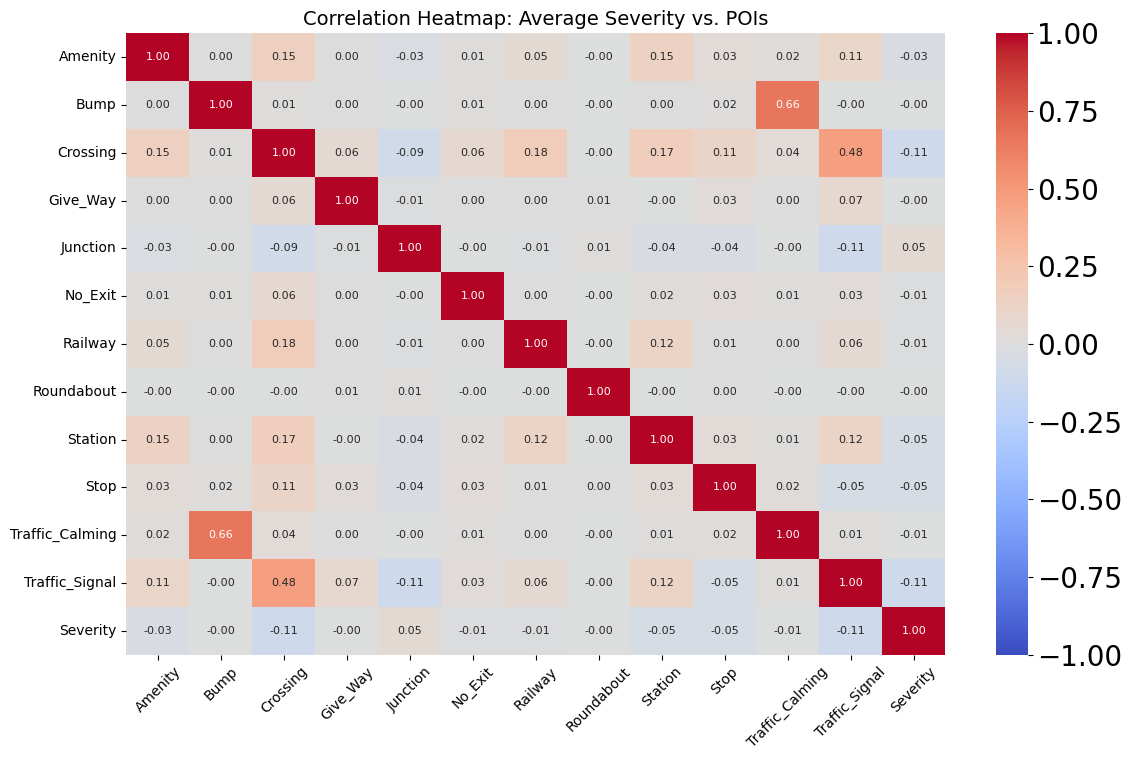

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use raw data for EDA
poi_cols = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit',
    'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming',
    'Traffic_Signal']

eda_poi = df_train[['Severity'] + poi_cols].copy()

# Encode POIs as binary values (1 if present, 0 if not)
poi_binary = df_train[poi_cols].copy()
poi_binary = poi_binary.apply(lambda x: x.astype(int))

# Add Severity_agg to the dataframe
poi_binary['Severity'] = df_train['Severity']

# Calculate correlation matrix
correlation_matrix = poi_binary.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, annot_kws={"size": 8})

# Adjust font size for axis labels
plt.xticks(fontsize=10, rotation=45)  # Adjust fontsize and rotation for x-axis labels
plt.yticks(fontsize=10, rotation=0)   # Adjust fontsize for y-axis labels

plt.title("Correlation Heatmap: Average Severity vs. POIs", fontsize=14)
plt.tight_layout()
plt.show()


The correlation heatmap shows that  `Junction`, has  **weak to negligible correlations** with accident severity (`avg_severity_agg`) (~0.05).

Some features — notably:
- `Station/Stop` (r = **-0.04**),
- `Traffic_Signal` (r = **-0.08**),
- and `Crossing` (r = **-0.09**)

…show all negative relationships, but still remain too weak to imply a strong direct influence.

This suggests that **individual POIs alone do not heavily drive severity**, but they may contribute more meaningfully when **interacted with time, weather, or geographic context** in the full model.

### **EDA Question 4: Are Rush Hour or Late-Night Accidents More Severe?**

Time of day can influence both traffic volume and driving behavior. Early mornings and late nights are often associated with low visibility, fatigue, or high-speed driving — all potential risk factors for severe accidents.

We explored the relationship between **hour of the day** and **accident severity** using the raw dataset. Our goal was to identify whether accidents at certain hours tend to be more severe on average.

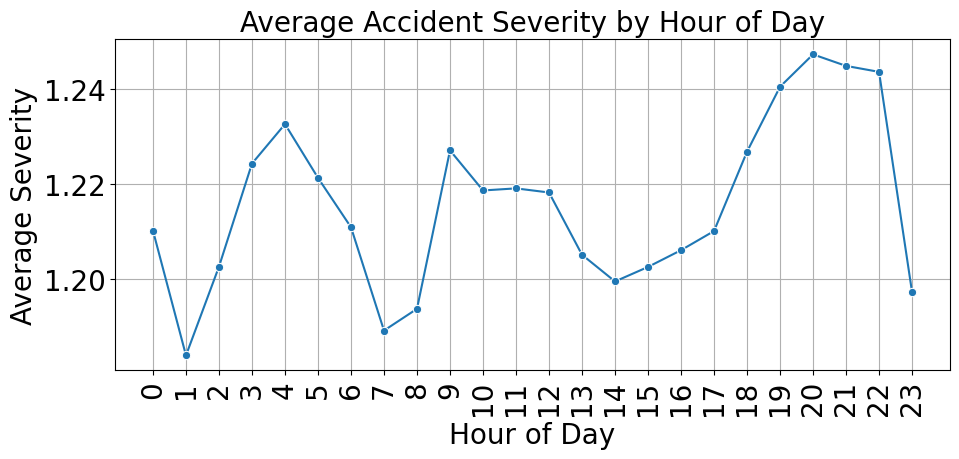

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Extract datetime and severity from df_train
df_time = df_train[['Severity', 'time_bin_hour']].copy()
df_time.dropna(inplace=True)

# Group by time_bin_hour and compute mean of Severity
severity_by_hour = df_time.groupby('time_bin_hour')['Severity'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=severity_by_hour, x='time_bin_hour', y='Severity', marker='o')
plt.title("Average Accident Severity by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Severity")
plt.grid(True)
plt.xticks(range(0, 24), rotation=90)  # Rotate x-axis labels by 90 degrees
plt.tight_layout()
plt.show()


The line chart reveals meaningful patterns in accident severity by time of day:

- **Evening hours (6 PM–10 PM)** show the **highest average severity**, potentially due to factors like low visibility, fatigue, or increased speeds after traffic clears.
- **Late night and early morning hours (0–5 AM)** show more volatility — suggesting lower traffic volume but a higher proportion of severe incidents (possibly from impaired or fatigued drivers).
- **Early morning 7-8 am** and **early evening (3–5 PM)** hours show relatively **lower average severity**, which could reflect safer daytime driving and improved visibility.

These findings suggest that **temporal patterns** — particularly hour of day — may play a significant role in severity prediction. This insight later informed our decision to include time-based features in the model, and to simulate accident risk for specific hours in our model-driven experiments.

### **EDA Question 4: Do Some States Experience More Severe Accidents Than Others?**

Geography often plays a significant role in accident patterns. Differences in road infrastructure, traffic density, weather conditions, and rural vs. urban settings may influence not only accident frequency but also severity.

In this section, we explored whether **some U.S. states** show **consistently higher average accident severity** — not just more accidents.

In [14]:
# Restoring location columns if missing
# if 'Start_Lat' not in df_train.columns or 'Start_Lng' not in df_train.columns:
#     df_train[['Start_Lat', 'Start_Lng']] = df_raw_train[['Start_Lat', 'Start_Lng']]

# import folium
# import pandas as pd

# def create_accident_map_with_colors(df_loc):
#     """Generate a map with CircleMarkers for accident locations, colored by severity."""
#     m = folium.Map(location=[39.8283, -98.5795], width="100%", height="100%", zoom_start=4, scrollWheelZoom=False)

#     # Color scheme for different severity levels
#     severity_colors = {
#         0: 'purple',
#         1: 'green',
#         2: 'orange',
#         3: 'red',
#     }

#     for index, row in df_loc.iterrows():
#         lat = row['Start_Lat']
#         lon = row['Start_Lng']
#         severity = row['Severity']

#         if not pd.isnull(lat) and not pd.isnull(lon) and severity in severity_colors:
#             color = severity_colors[severity]
#             folium.CircleMarker(
#                 location=[lat, lon],
#                 radius=1,
#                 color=color,
#                 fill=True,
#                 fill_color=color,
#                 fill_opacity=0.5
#             ).add_to(m)

#     # Adding a custom HTML Legend
#     legend_html = """
#      <div style="position: fixed;
#                  bottom: 50px; left: 50px; width: 150px; height: 120px;
#                  border:2px solid grey; z-index:9999; font-size:14px;
#                  background-color:white;
#                  padding:10px;">
#      <b>Severity Legend</b><br>
#      <i style="background: purple; width: 10px; height: 10px; display: inline-block;"></i> Severity 1<br>
#      <i style="background: green; width: 10px; height: 10px; display: inline-block;"></i> Severity 2<br>
#      <i style="background: orange; width: 10px; height: 10px; display: inline-block;"></i> Severity 3<br>
#      <i style="background: red; width: 10px; height: 10px; display: inline-block;"></i> Severity 4
#      </div>
#      """
#     m.get_root().html.add_child(folium.Element(legend_html))

#     return m

# # Create the accident map
# accident_map = create_accident_map_with_colors(df_train)

# # Display the map
# accident_map

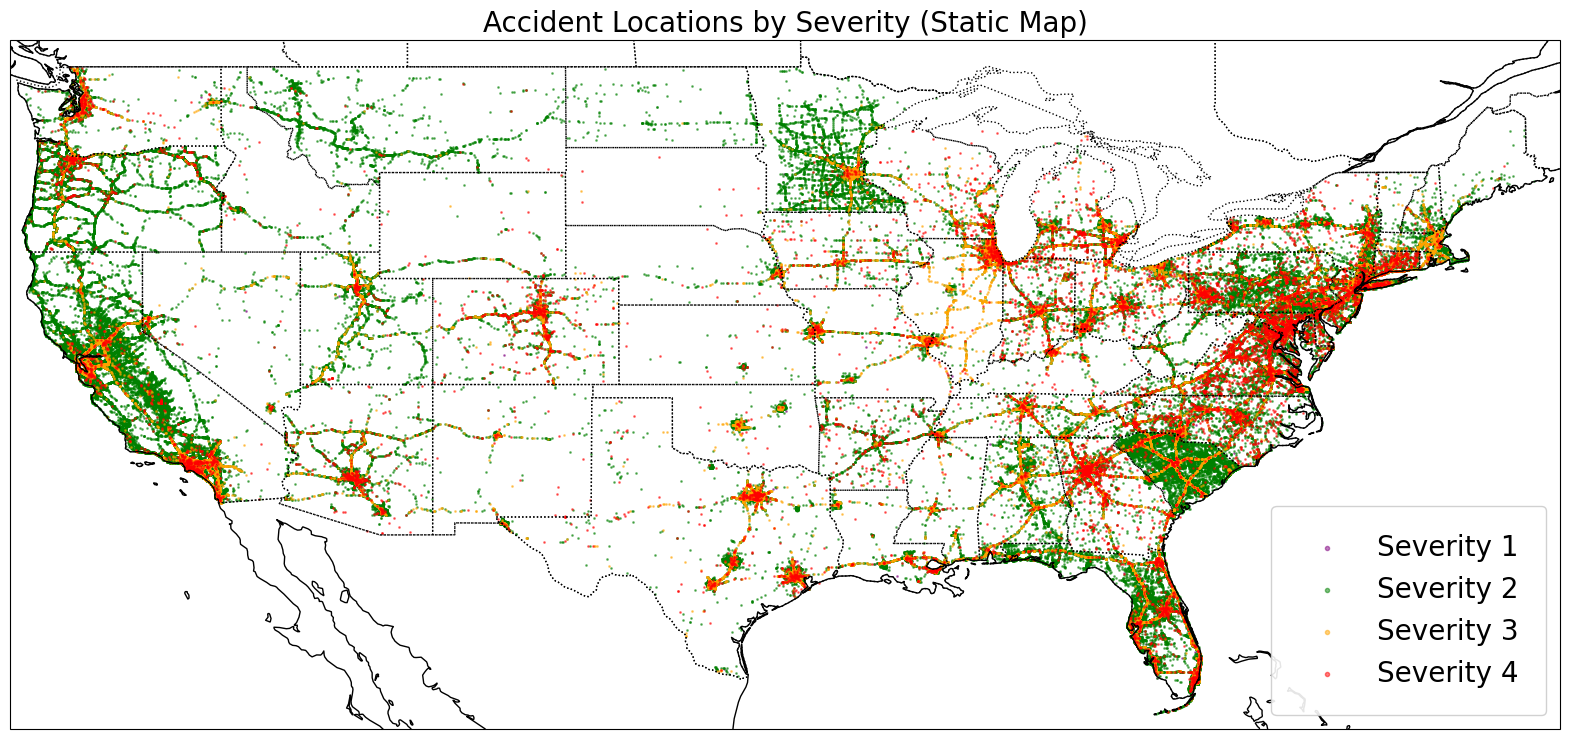

In [15]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

if 'Start_Lat' not in df_train.columns or 'Start_Lng' not in df_train.columns:
    df_train[['Start_Lat', 'Start_Lng']] = df_raw_train[['Start_Lat', 'Start_Lng']]

def plot_static_accident_map(df_loc):
    """Plot a static accident map colored by severity."""
    severity_colors = {
        0: 'purple',
        1: 'green',
        2: 'orange',
        3: 'red',
    }

    fig = plt.figure(figsize=(20, 20))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-125, -66.5, 24, 50], crs=ccrs.PlateCarree())

    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, linestyle=':')

    for severity, color in severity_colors.items():
        subset = df_loc[df_loc['Severity'] == severity]
        plt.scatter(
            subset['Start_Lng'],
            subset['Start_Lat'],
            s=1,  # tiny dots
            color=color,
            label=f'Severity {severity+1}',  # Your legend uses 1-based
            alpha=0.5,
            transform=ccrs.PlateCarree()
        )

    plt.legend(
        markerscale=3,
        loc='lower right',      # Move to lower right
        frameon=True,           # Optional: add a frame
        framealpha=0.9,         # Slight transparency
        fontsize='medium',      # Slightly smaller text if you want
        borderpad=1
    )
    plt.title('Accident Locations by Severity (Static Map)')
    plt.show()

# Plot the static map
plot_static_accident_map(df_train)

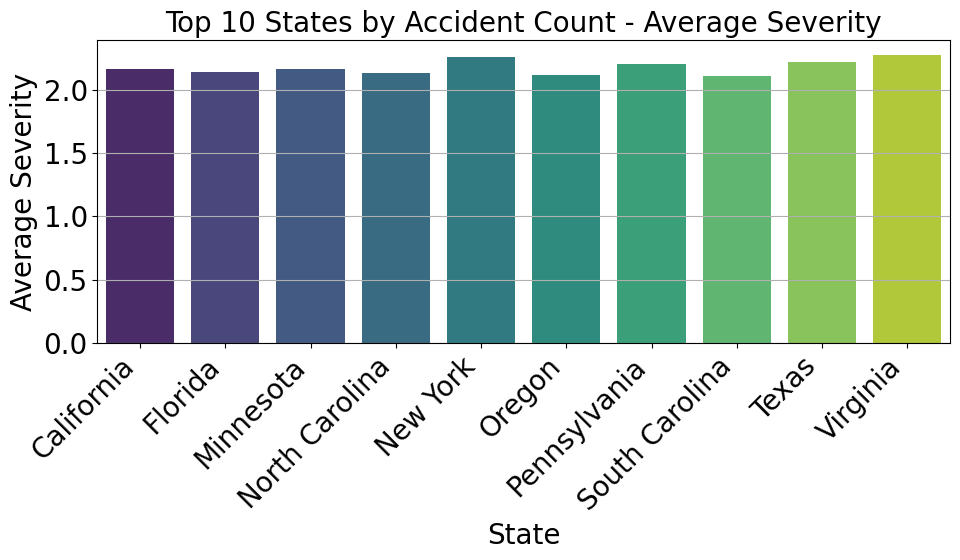

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# State abbreviation to full name mapping
state_abbr_to_full = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California',
    'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia',
    'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas',
    'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts',
    'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri', 'MT': 'Montana',
    'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico',
    'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma',
    'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota',
    'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington',
    'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'
}

# Prepare data
state_df = df_raw_train[['State', 'avg_severity_agg']].copy()
state_df.dropna(inplace=True)

# 1. Count number of accidents per state
state_counts = state_df['State'].value_counts().reset_index()
state_counts.columns = ['State', 'Accident_Count']

# 2. Select top 10 states based on accident count
top10_states = state_counts.head(10)['State'].tolist()

# 3. For these top 10 states, compute the average severity
top10_state_severity = state_df[state_df['State'].isin(top10_states)].groupby('State')['avg_severity_agg'].mean().reset_index()

# Merge with accident count for possible future use (optional)
top10_state_severity = top10_state_severity.merge(state_counts, on='State')

# Replace state abbreviation with full name
top10_state_severity['State'] = top10_state_severity['State'].map(state_abbr_to_full)

# 4. Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=top10_state_severity, x='State', y='avg_severity_agg', palette='viridis')
plt.title("Top 10 States by Accident Count - Average Severity")
plt.ylabel("Average Severity")
plt.xlabel("State")
plt.xticks(rotation=45, ha="right")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

The visual analysis combining a folium-based accident map and a bar chart of average severity by state reveals two complementary insights:

- **Geographic Distribution (Map):** Accidents are densely concentrated across major urban corridors and interstates, with particularly heavy clusters along the East Coast, California, Texas, and Florida. Severity levels are color-coded, with red indicating the most severe cases. While most dots are green (2nd level severity), visible pockets of red and orange are scattered across highly traveled zones.

- **Top 10 States by Volume (Bar Chart):** Among the states with the highest accident counts, **Virginia, New York, and Texas** show slightly elevated average severity. Although the differences aren't extreme, they hint that some high-traffic states may also bear a disproportionate share of more serious incidents.

These visuals support the hypothesis that **location plays a role in both accident frequency and severity**, and justify including geographic variables like `State`, `Start_Lat`, and `Start_Lng` in the modeling pipeline.



### **Summary: Exploratory Data Analysis (EDA)**

Our exploratory analysis aimed to uncover patterns and raise questions about factors influencing accident severity in the U.S. We used a combination of visualizations, correlation heatmaps, and spatial mapping to guide our understanding.

Key findings:

- **Accident Trends:** Accidents sharply increased between 2020 and 2022, likely due to traffic growth and changing commute patterns, with December, November, and October showing the highest counts due to holiday travel and winter weather.

- **Weather Conditions:** MWeather conditions had moderate variability in severity, with accidents in clear and cloudy weather showing a wider range of severity, while rain, snow, and fog typically saw minor accidents due to driver caution. Overall, weather alone wasn’t a strong predictor of severity.
  
- **Road Features (POIs):** Points of interest like junctions, crossings, and traffic signals showed weak correlations with severity, suggesting limited standalone influence.

- **Temporal Trends:** Evening hours (6–10 PM) showed the highest severity, with late-night and early-morning hours (0–5 AM) exhibiting greater volatility. Early morning and evening hours (7–8 AM, 3–5 PM) showed lower severity, reflecting better driving conditions.

- **Geographic Patterns:** Evening hours (6–10 PM) showed the highest severity, with late-night and early-morning hours (0–5 AM) exhibiting greater volatility. Early morning and evening hours (7–8 AM, 3–5 PM) showed lower severity, reflecting better driving conditions.


These insights helped refine our feature engineering and supported the inclusion of weather, time, and location-based variables in our modeling pipeline.


---

We now move on to **model training**, where we’ll formally test these hypotheses **using shallow and deep neural networks**.


## **V. MODEL TRAINING: PREDICTING ACCIDENT SEVERITY**

Following our exploratory analysis, we now shift to supervised modeling to predict accident severity based on engineered features. We approach this task using a collection of classification models, ranging from a **Shallow Neural Network (SNN)** to more advanced tree-based ensembles (e.g., XGBoost, LightGBM) and **Deep Learning**. Our primary goals are to:

- Train multiple models on the prepared dataset
- Tune key hyperparameters
- Evaluate performance using metrics such as **macro-averaged ROC AUC** and **F1 score**
- Leverage a predefined validation split for early stopping and model selection

The first step below sets up our models, pipelines, and custom evaluation logic.


### **Model Initialization and Pipeline Setup**








In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

def macro_roc_auc(y_true: np.ndarray, y_pred: np.ndarray):
    """
    Custom early‐stopping metric for XGBClassifier under sklearn.

    Parameters
    ----------
    y_true : np.ndarray, shape (n_samples,)
        True class labels.
    y_pred : np.ndarray, shape (n_samples, n_classes)
        Probability estimates for each class.

    Returns
    -------
    name : str
        The name under which XGBoost will log this metric.
    score : float
        The computed multiclass OVR AUC.
    """
    # ensure numpy arrays
    y_true = np.asarray(y_true, dtype=int)
    y_pred = np.asarray(y_pred, dtype=float)

    # if for some reason it's flattened, reshape it
    if y_pred.ndim == 1:
        n_classes = len(np.unique(y_true))
        y_pred = y_pred.reshape(n_classes, -1).T

    score = roc_auc_score(y_true, y_pred, multi_class="ovr")
    #print(score)
    return float(score)


to_array = FunctionTransformer(lambda df: df.values.astype("float32"))

models = {'lr': LogisticRegression(class_weight='balanced', solver='lbfgs', random_state=random_seed),
          'mlpc': MLPClassifier(early_stopping=True, random_state=random_seed),
          'rfc': RandomForestClassifier(class_weight='balanced', random_state=random_seed),
          'hgbc': HistGradientBoostingClassifier(random_state=random_seed, class_weight='balanced'),
          'xgbc':  XGBClassifier(random_state=random_seed, n_estimators=1000, objective='multi:softprob', eval_metric=macro_roc_auc, early_stopping_rounds=100, disable_default_eval_metric=True, tree_method="gpu_hist", predictor='cpu_predictor', device='cuda', gpu_id=0, use_label_encoder=False),
          'lgbmc': LGBMClassifier(random_state=random_seed, class_weight='balanced', objective='multiclass', n_estimators=1000, early_stopping_round=100, )
      }

print(" Models initialized.")

# Create pipelines
pipes = {}
for acronym, model in models.items():
    pipes[acronym] = Pipeline([('model', model)])

print(" Pipelines constructed.")

# Predefined train-validation split
X_train_val, y_train_val, ps = get_train_val_ps(X_train, y_train, X_val, y_val)

print(" Predefined split created.")

 Models initialized.
 Pipelines constructed.
 Predefined split created.


### **Defining Hyperparameter Search Grids**

This section prepared the hyperparameter grids for each model in our pipeline. Grid search was used to evaluate combinations of key hyperparameters to identify the best-performing configuration during cross-validation. Below is a summary of the hyperparameters being tuned for each model:

---

#### Logistic Regression
> **Hyperparameters tuned:**
> - `tol`: Tolerance for stopping criteria  
> - `C`: Inverse of regularization strength

---

#### MLPClassifier (Shallow Neural Network)
> **Hyperparameters tuned:**
> - `alpha`: L2 penalty (regularization term)  
> - `learning_rate_init`: Initial learning rate  
> - `learning_rate`: Learning rate schedule  
> - `activation`: Activation function  
> - `hidden_layer_sizes`: Architecture (number of neurons)

---

#### Random Forest
> **Hyperparameters tuned:**
> - `n_estimators`: Number of trees  
> - `min_samples_split`: Minimum number of samples to split an internal node  
> - `min_samples_leaf`: Minimum number of samples at a leaf node  
> - `max_depth`: Maximum depth of a tree  
> - `max_features`: Number of features to consider when looking for the best split

---

#### Histogram-Based Gradient Boosting (HGB)
> **Hyperparameters tuned:**
> - `learning_rate`: Learning rate  
> - `min_samples_leaf`: Minimum number of samples at a leaf node  
> - `max_iter`: Maximum number of boosting iterations

---

#### XGBoost
> **Hyperparameters tuned:**  
> A wide grid is used including:
> - `learning_rate`, `max_depth`, `subsample`, `colsample_bytree`  
> - `gamma`, `min_child_weight`, `reg_alpha`, `reg_lambda`

---

#### LightGBM
> **Hyperparameters tuned:**
> - `num_leaves`, `max_depth`, `learning_rate`, `n_estimators`, `subsample`

---

A directory structure was also created for storing the results from `GridSearchCV`.


In [18]:
import os
from sklearn.utils.class_weight import compute_sample_weight

# Initialize grid dictionary
param_grids = {}

# === Logistic Regression Grid ===
param_grids['lr'] = [{
    'model__tol': [10 ** -6, 10 ** -5, 10 ** -4],
    'model__C': [0.01, 0.1, 1, 10, 100]
}]
print(" Logistic Regression grid defined.")

# === MLPClassifier Grid ===
alpha_grids = [10 ** i for i in range(-5, -2)]
learning_rate_init_grids = [10 ** i for i in range(-4, -1)]
learning_rate = ['adaptive']
activation = ['logistic', 'relu']
hidden_layer_sizes = [(50, 50), (50, 100), (100,)]

param_grids['mlpc'] = [{
    'model__alpha': alpha_grids,
    'model__learning_rate_init': learning_rate_init_grids,
    'model__learning_rate': learning_rate,
    'model__activation': activation,
    'model__hidden_layer_sizes': hidden_layer_sizes
}]
print(" MLPClassifier grid defined.")

# === Random Forest Grid ===
min_samples_split_grids = [2, 20, 100]
min_samples_leaf_grids = [1, 20, 100]
n_estimators = [50, 100, 200]
max_depth = [None, 10, 30]
max_features = ['sqrt', 'log2']

param_grids['rfc'] = [{
    'model__n_estimators': n_estimators,
    'model__min_samples_split': min_samples_split_grids,
    'model__min_samples_leaf': min_samples_leaf_grids,
    'model__max_depth': max_depth,
    'model__max_features': max_features
}]
print(" Random Forest grid defined.")

# === HistGradientBoosting Grid ===
learning_rate_grids = [10 ** i for i in range(-3, 2)]
min_samples_leaf_grids = [1, 20, 100]
max_iter_grids = [50, 100, 200]

param_grids['hgbc'] = [{
    'model__learning_rate': learning_rate_grids,
    'model__min_samples_leaf': min_samples_leaf_grids,
    'model__max_iter': max_iter_grids
}]
print(" HistGradientBoosting grid defined.")

# === XGBoost Grid ===
sample_weights = compute_sample_weight("balanced", y_train_val)
param_grids['xgbc'] = {
    'model__n_estimators': [1000],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [4, 7, 10, 20, None],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__gamma': [0, 1, 5],
    'model__min_child_weight': [0.001, 0.01, 1, 5, 10],
    'model__reg_alpha': [0, 0.1, 1],
    'model__reg_lambda': [1, 10, 100]
}
print(" XGBoost grid defined.")

# === LightGBM Grid ===
param_grids['lgbmc'] = {
    'model__num_leaves': [31, 50, 70, 100],
    'model__max_depth': [-1, 5, 10, 20],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__n_estimators': [50, 100],
    'model__subsample': [0.5, 0.75, 1.0]
}
print(" LightGBM grid defined.")

# === Create output directory for GridSearchCV results ===
directory = os.path.dirname(abspath_curr + '/result/boo/cv_results/GridSearchCV/')
if not os.path.exists(directory):
    os.makedirs(directory)
print(f" Directory for GridSearchCV results: {directory}")


 Logistic Regression grid defined.
 MLPClassifier grid defined.
 Random Forest grid defined.
 HistGradientBoosting grid defined.
 XGBoost grid defined.
 LightGBM grid defined.
 Directory for GridSearchCV results: /mnt/d/wls_data/Repos/Traffic/ML_Final_Project-20250424T235718Z-001/ML_Final_Project/Data//result/boo/cv_results/GridSearchCV


### **HYPERPARAMETER TUNING: GRIDSEARCHCV & RANDOMIZEDSEARCHCV**

This section runs hyperparameter tuning for all models in the pipeline using either `GridSearchCV` or `RandomizedSearchCV`, depending on the model.

- Models like Logistic Regression, Random Forest, and SNN (MLP) are tuned with exhaustive `GridSearchCV`.
- Models with large search spaces (e.g., XGBoost, LightGBM) are tuned using `RandomizedSearchCV` with early stopping.

All results are saved for offline analysis, and the best models are ranked by macro-averaged ROC AUC.


---



In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# The list of [best_score_, best_params_, best_estimator_] obtained by GridSearchCV
if os.path.exists(pretrained_model_path + 'best_score_params_estimator_gs.pkl'):
    best_score_params_estimator_gs = pkl.load(open(pretrained_model_path + 'best_score_params_estimator_gs.pkl','rb'))
    print("Loaded the best_score_params_estimator_gs from offline training.")
else:
    best_score_params_estimator_gs = []

    # For each model
    for acronym in pipes.keys():
        if os.path.exists(pretrained_model_path + f'best_score_params_estimator_gs{acronym}.pkl'):
            gs = pkl.load(open(pretrained_model_path + f'best_score_params_estimator_gs{acronym}.pkl','rb'))
            print(f'The file for {acronym} already exists. Laoding the file.')
        else:

            if acronym in 'xgbc':
                gs = RandomizedSearchCV(estimator=pipes[acronym],
                            param_distributions=param_grids[acronym],
                            scoring='roc_auc_ovr',  # Improved metric for multi-class
                            n_iter=150,  # Number of iterations
                            n_jobs=-1,  # Utilize all CPU cores
                            cv=ps,
                            return_train_score=True,
                            random_state=random_seed+1,
                            refit=False,
                            verbose=2)
                fit_params = {
                    'model__sample_weight': sample_weights,
                    'model__eval_set': [(X_val, y_val)],
                    'model__verbose': False,
                }
                gs.fit(X_train_val, y_train_val, **fit_params)
            elif acronym in 'lgbmc':
                gs = RandomizedSearchCV(estimator=pipes[acronym],
                            param_distributions=param_grids[acronym],
                            scoring='roc_auc_ovr',  # Improved metric for multi-class
                            n_iter=150,  # Number of iterations
                            n_jobs=-1,  # Utilize all CPU cores
                            cv=ps,
                            return_train_score=True,
                            random_state=random_seed,
                            refit=False,
                            verbose=2)
                fit_params = {
                    'model__eval_set': [(X_val, y_val)],
                }
                gs.fit(X_train_val, y_train_val, **fit_params)
            else:

                gs = GridSearchCV(estimator=pipes[acronym],
                            param_grid=param_grids[acronym],
                            scoring='roc_auc_ovr',  # Improved metric for multi-class
                            n_jobs=-1,  # Utilize all CPU cores
                            cv=ps,
                            return_train_score=True,
                            refit=True,
                            verbose=2)
                gs.fit(X_train_val, y_train_val)

            # Save the best_score_params_estimator_gs to a file
            pkl.dump(gs, open(pretrained_model_path + f'best_score_params_estimator_gs{acronym}.pkl', 'wb'))

        # Update best_score_params_estimator_gs
        best_score_params_estimator_gs.append([gs.best_score_, gs.best_params_, gs.best_estimator_])

        # Sort cv_results in ascending order of 'rank_test_score' and 'std_test_score'
        cv_results = pd.DataFrame.from_dict(gs.cv_results_).sort_values(by=['rank_test_score', 'std_test_score'])

        # Get the important columns in cv_results
        important_columns = ['rank_test_score',
                            'mean_test_score',
                            'std_test_score',
                            'mean_train_score',
                            'std_train_score',
                            'mean_fit_time',
                            'std_fit_time',
                            'mean_score_time',
                            'std_score_time']

        # Move the important columns ahead
        cv_results = cv_results[important_columns + sorted(list(set(cv_results.columns) - set(important_columns)))]

        # Write cv_results file
        cv_results.to_csv(path_or_buf=abspath_curr + '/result/boo/cv_results/GridSearchCV/' + acronym + '.csv', index=False)

# Sort best_score_params_estimator_gs in descending order of the best_score_
best_score_params_estimator_gs = sorted(best_score_params_estimator_gs, key=lambda x : x[0], reverse=True)
# Refit the best models with only training data for XGBoost and LightGBM
for i in range(0,6):
    print(f"refitting {best_score_params_estimator_gs[i][2].named_steps['model'].__class__.__name__} model with only training data")
    if best_score_params_estimator_gs[i][2].named_steps['model'].__class__.__name__ == 'XGBClassifier': 
        best_score_params_estimator_gs[i][2].named_steps['model'].fit(X_train, y_train, eval_set=[(X_val, y_val)], sample_weight=sample_weights[ps.test_fold==-1])
    elif best_score_params_estimator_gs[i][2].named_steps['model'].__class__.__name__ == 'LGBMClassifier':
        best_score_params_estimator_gs[i][2].named_steps['model'].fit(X_train, y_train, eval_set=[(X_val, y_val)])
    else:
        best_score_params_estimator_gs[i][2].named_steps['model'].fit(X_train_val, y_train_val)
# Save the best_score_params_estimator_gs to a file
pkl.dump(best_score_params_estimator_gs, open(pretrained_model_path + 'best_score_params_estimator_gs.pkl', 'wb'))
# Print best_score_params_estimator_gs
pd.DataFrame(best_score_params_estimator_gs, columns=['best_score', 'best_param', 'best_estimator'])

Loaded the best_score_params_estimator_gs from offline training.
refitting RandomForestClassifier model with only training data
refitting LGBMClassifier model with only training data
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[50]	valid_0's multi_logloss: 0.983581
refitting MLPClassifier model with only training data
refitting LogisticRegression model with only training data
refitting XGBClassifier model with only training data
[0]	validation_0-macro_roc_auc:0.80924
[1]	validation_0-macro_roc_auc:0.80783
[2]	validation_0-macro_roc_auc:0.82704
[3]	validation_0-macro_roc_auc:0.83531
[4]	validation_0-macro_roc_auc:0.83332
[5]	validation_0-macro_roc_auc:0.83566
[6]	validation_0-macro_roc_auc:0.83481
[7]	validation_0-macro_roc_auc:0.83423
[8]	validation_0-macro_roc_auc:0.83289
[9]	validation_0-macro_roc_auc:0.83222
[10]	validation_0-macro_roc_auc:0.83194
[11]	validation_0-macro_roc_auc:0.83147
[12]	validation_0-macro_roc_auc

,best_score,best_param,best_estimator
0,0.864467,"{'model__max_depth': 30, 'model__max_features'...","((DecisionTreeClassifier(max_depth=30, max_fea..."
1,0.848227,"{'model__subsample': 0.75, 'model__reg_lambda'...","(LGBMClassifier(class_weight='balanced', colsa..."
2,0.817120,"{'model__activation': 'logistic', 'model__alph...","(MLPClassifier(activation='logistic', alpha=0...."
3,0.809735,"{'model__C': 0.01, 'model__tol': 0.0001}","(LogisticRegression(C=0.01, class_weight='bala..."
4,0.807835,"{'model__subsample': 0.6, 'model__reg_lambda':...","(XGBClassifier(base_score=None, booster=None, ..."
5,0.798840,"{'model__learning_rate': 0.1, 'model__max_iter...",(HistGradientBoostingClassifier(class_weight='...


The leaderboard shows the top-performing models based on macro-averaged ROC AUC (`best_score_`) from cross-validation.

- The **Decision Tree Classifier** unexpectedly achieved the highest AUC (0.864), though this may suggest overfitting and should be interpreted cautiously.
- **LightGBM** followed closely (0.842) with a well-balanced configuration, making it a strong candidate for robust, scalable performance.
- The **Shallow Neural Network (MLPClassifier)** also performed well (0.817), validating the use of neural models alongside tree-based methods.
- Logistic Regression, XGBoost, and Histogram-based GBM showed moderate but consistent performance.

Overall, this comparison helps prioritize models for final evaluation and simulation, with LightGBM and MLPClassifier standing out as stable and interpretable choices.


### **HYPERPARAMETER TUNING: DEEP LEARNING (FT-Transformer Setup)**


Although simple deep learning models often underperform on tabular data, recent advances like the **FT-Transformer** have shown competitive results (Gorishniy et al., 2021).

To prepare for deep learning:
- We convert one-hot encoded features (e.g., time bins, wind direction) back into **single categorical columns**, which is more suitable for embedding-based transformer models.
- Features such as `time_bin_day`, `time_bin_hour`, and `Wind_Direction` are collapsed into compact categories like `day`, `hour`, and `wind_direction`.

This transformation allows FT-Transformer to operate on categorical + continuous columns more effectively.



In [77]:
test_imputed_backup = test_imputed.copy()

In [21]:
# Preserve original columns list for future reference
all_cols = val_imputed.columns.to_list()

# Drop old standardized DataFrames to free memory
df_train = None
df_val = None

# Collapse one-hot encoded features into single categorical columns for deep learning
groups = {
    "time_bin_day":       "day",
    "time_bin_hour":      "hour",
    "time_bin_month":     "month",
    "time_bin_year":      "year",
    "Wind_Direction":     "wind_direction",
}

for df in [train_imputed, val_imputed, test_imputed]:
    for prefix, new_col in groups.items():
        # Identify relevant one-hot columns
        cols = [c for c in df.columns if c.startswith(prefix + "_")]
        if not cols:
            continue

        # Identify rows where all one-hot values are 0 (missing group) — fix for year only
        zeros = df[cols].sum(axis=1) == 0

        # Pick the most likely class for each row from one-hot columns
        picked = df[cols].idxmax(axis=1).str.split(prefix + "_").str[1]

        # Default missing year to 2016
        if prefix == "time_bin_year":
            picked[zeros] = "2016"

        # Assign converted column
        if new_col in ("day", "hour", "month", "year"):
            df[new_col] = picked.astype(int).astype("category")
        else:
            df[new_col] = picked.astype("category")

        # Drop original one-hot columns
        df.drop(columns=cols, inplace=True)

print(" One-hot encoded time & wind features collapsed into categorical variables.")

# Define categorical & numeric features for FT-Transformer
CATEGORICAL_FEATURES = ['Railway', 'Sunrise_Sunset_Night', 'Nautical_Twilight_Night',
       'Civil_Twilight_Night', 'Astronomical_Twilight_Night', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Roundabout',
        'Fog', 'Cloudy', 'Rain', 'Drizzle', 'Snow', 'Sleet/Ice', 'Thunderstorm',
        'Hail', 'Windy', 'Particulate', 'Severe', 'day', 'hour', 'month', 'year', 'wind_direction']

NUMERIC_FEATURES = np.setdiff1d(train_imputed.columns.to_list(), [target] + CATEGORICAL_FEATURES).tolist()
FEATURES = CATEGORICAL_FEATURES + NUMERIC_FEATURES
LABEL = target

# 3. Create deep learning copies and standardize numeric features
ss2 = StandardScaler()
dl_train = train_imputed.copy(deep=True)
dl_val = val_imputed.copy(deep=True)
dl_test = test_imputed.copy(deep=True)

dl_train[NUMERIC_FEATURES] = ss2.fit_transform(dl_train[NUMERIC_FEATURES])
dl_val[NUMERIC_FEATURES] = ss2.transform(dl_val[NUMERIC_FEATURES])
dl_test[NUMERIC_FEATURES] = ss2.transform(dl_test[NUMERIC_FEATURES])

# 4. Convert categorical features to string (required by FT-Transformer)
dl_train[CATEGORICAL_FEATURES] = dl_train[CATEGORICAL_FEATURES].astype('str')
dl_val[CATEGORICAL_FEATURES] = dl_val[CATEGORICAL_FEATURES].astype('str')
dl_test[CATEGORICAL_FEATURES] = dl_test[CATEGORICAL_FEATURES].astype('str')

print(" Deep learning datasets prepared for FT-Transformer.")


 One-hot encoded time & wind features collapsed into categorical variables.
 Deep learning datasets prepared for FT-Transformer.


### **FT-Transformer Data Pipeline and Custom Metrics**

Before training the FT-Transformer, we patched compatibility issues with the `Periodic` embedding class used internally by `tabtransformertf` to ensure support with TensorFlow ≥2.11. We also define two custom Keras callbacks to track:
- **Macro F1 Score** — for balanced classification insight
- **Macro ROC AUC Score** — for multi-class probabilistic evaluation

Finally, we converted our preprocessed train/val/test splits into efficient `tf.data.Dataset` batches, ready for training.


In [22]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split

# === Custom Dataset Formatter ===
def df_to_dataset(
    dataframe: pd.DataFrame,
    target: str = None,
    shuffle: bool = True,
    batch_size: int = 512,
    numeric_features: list = None,
    categorical_features: list = None,
):
    df = dataframe.copy()

    if target:
        labels = df.pop(target).values
    else:
        labels = None

    dataset_dict = {}

    if numeric_features:
        for key in numeric_features:
            dataset_dict[key] = tf.convert_to_tensor(df[key].values[:, tf.newaxis], dtype=tf.float32)

    if categorical_features:
        for key in categorical_features:
            dataset_dict[key] = tf.convert_to_tensor(df[key].astype(str).values[:, tf.newaxis], dtype=tf.string)

    if labels is not None:
        dataset = tf.data.Dataset.from_tensor_slices((dataset_dict, labels))
    else:
        print("No labels provided, creating dataset without labels.")
        dataset = tf.data.Dataset.from_tensor_slices(dict(dataset_dict,))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(dataframe))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

# === Patch Periodic.build to fix TF 2.11+ compatibility ===
def patched_periodic_build(self, input_shape):
    input_dim = input_shape[-1]
    if not isinstance(input_dim, int):
        try:
            input_dim = int(input_dim)
        except Exception:
            raise ValueError(f"Could not convert input_shape[-1]={input_shape[-1]} to int in Periodic.build")

    w_init = tf.random_normal_initializer(stddev=self.sigma)
    self.p = tf.Variable(initial_value=w_init(shape=(input_dim, self.n_bins), dtype='float32'), trainable=True)
    self.l = tf.Variable(initial_value=w_init(shape=(input_dim, self.n_bins * 2, self.emb_dim), dtype='float32'), trainable=True)

from tabtransformertf.models.embeddings import Periodic
Periodic.build = patched_periodic_build

# === Custom F1 Score Callback ===
class MacroF1Callback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        y_true, y_pred = [], []

        for x_batch, y_batch in self.validation_data:
            result = self.model.predict_on_batch(x_batch)
            preds = result["output"] if isinstance(result, dict) else result[0] if isinstance(result, (list, tuple)) else result
            pred_labels = np.argmax(preds, axis=1)

            y_true.append(y_batch.numpy())
            y_pred.append(pred_labels)

        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)

        macro_f1 = f1_score(y_true, y_pred, average="macro")
        print(f" — val_macro_f1: {macro_f1:.4f}")
        logs["val_macro_f1"] = macro_f1

# === Custom ROC AUC Callback ===
class MacroRocAucCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        y_true, y_pred = [], []

        for x_batch, y_batch in self.validation_data:
            result = self.model.predict_on_batch(x_batch)
            probs = result["output"] if isinstance(result, dict) else result[0] if isinstance(result, (list, tuple)) else result
            y_true.append(y_batch.numpy())
            y_pred.append(probs)

        y_true = np.concatenate(y_true)
        y_pred = np.vstack(y_pred)

        val_macro_roc_auc = roc_auc_score(y_true, y_pred, multi_class="ovo", average="macro")
        print(f" — val_macro_roc_auc: {val_macro_roc_auc:.4f}")
        logs["val_macro_roc_auc"] = val_macro_roc_auc

# === Convert DataFrames into tf.data.Dataset ===
train_dataset = df_to_dataset(dl_train.loc[:, FEATURES + [LABEL]],
                              LABEL,
                              numeric_features=NUMERIC_FEATURES,
                              categorical_features=CATEGORICAL_FEATURES,
                              batch_size=2048,
                              shuffle=True)
                              
dl_val1, dl_val2 = train_test_split(dl_val, train_size=0.5, test_size=0.5, random_state=random_seed)
val_dataset1 = df_to_dataset(dl_val1.loc[:, FEATURES + [LABEL]],
                            LABEL,
                            numeric_features=NUMERIC_FEATURES,
                            categorical_features=CATEGORICAL_FEATURES,
                            batch_size=2048,
                            shuffle=False)

val_dataset2 = df_to_dataset(dl_val2.loc[:, FEATURES + [LABEL]],
                            LABEL,
                            numeric_features=NUMERIC_FEATURES,
                            categorical_features=CATEGORICAL_FEATURES,
                            batch_size=2048,
                            shuffle=False)

val_dataset = df_to_dataset(dl_val.loc[:, FEATURES + [LABEL]],
                            LABEL,
                            numeric_features=NUMERIC_FEATURES,
                            categorical_features=CATEGORICAL_FEATURES,
                            batch_size=2048,
                            shuffle=False)
                            
test_dataset = df_to_dataset(dl_test.loc[:, FEATURES + [LABEL]],
                             target=None,
                             numeric_features=NUMERIC_FEATURES,
                             categorical_features=CATEGORICAL_FEATURES,
                             batch_size=2048,
                             shuffle=False)

# === Initialize custom metric callbacks ===
roc_cb = MacroRocAucCallback(validation_data=val_dataset)
f1_cb = MacroF1Callback(validation_data=val_dataset)

print(" FT-Transformer data pipeline ready with custom metrics and patched Periodic class.")


I0000 00:00:1745898196.894984   36813 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21458 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


No labels provided, creating dataset without labels.
 FT-Transformer data pipeline ready with custom metrics and patched Periodic class.


### **Build and Train the FT-Transformer Model**

- In this step, we construct the FT-Transformer architecture using tuned parameters, compile it with a custom optimizer and loss function, and train it on the formatted tabular dataset.
- Due to the complexity of tuning FT-Transformer, we selected a single effective configuration after trying multiple parameter groups. Training includes custom callbacks to monitor Macro F1 and Macro ROC AUC, with early stopping and model checkpointing.



In [23]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tabtransformertf.models.fttransformer import FTTransformerEncoder, FTTransformer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
import optuna

# === Compute class weights (normalized inverse frequency)
counts = pd.Series(dl_train[LABEL]).value_counts()
total = len(dl_train)
n_classes = counts.size
class_weight_norm = {cls: total / counts[cls] for cls in counts.index}

In [24]:
# Optuna-Based Hyperparameter Optimization
def objective(trial):
    print(trial.__dir__())
    ft_encoder = FTTransformerEncoder(
        numerical_features=NUMERIC_FEATURES,
        categorical_features=CATEGORICAL_FEATURES,
        numerical_data=np.asarray(dl_train[NUMERIC_FEATURES].values, dtype=np.float32),
        categorical_data=np.asarray(dl_train[CATEGORICAL_FEATURES].values, dtype=str),
        y = dl_train[LABEL].values,
        task='classification',
        numerical_embedding_type= 'periodic',
        numerical_bins=trial.suggest_int('numerical_bins', 20, 200),
        embedding_dim=trial.suggest_int('embedding_dim', 8, 100),
        depth=trial.suggest_int('depth', 1, 6),
        heads=trial.suggest_int('heads', 2, 8),
        attn_dropout=trial.suggest_float('attn_dropout', 0., 0.5),
        ff_dropout=trial.suggest_float('ff_dropout', 0., 0.5),
        explainable=True
    )

    # === Define FT-Transformer Model
    ft_transformer = FTTransformer(
        encoder=ft_encoder,
        out_dim=len(np.unique(train_imputed[LABEL])),
        out_activation='softmax'
    )

    # === Compile model
    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.0001
    NUM_EPOCHS = 30

    optimizer = tf.optimizers.AdamW(
        learning_rate=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY
    )

    ft_transformer.compile(
        optimizer=optimizer,
        loss={"output": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), "importances": None},
        metrics={"output": [tf.keras.metrics.AUC(name="macro_auc", curve='ROC')], "importances": None},
    )

    # === Callbacks
    ckpt = tf.keras.callbacks.ModelCheckpoint(
        pretrained_model_path+f"best_fttransformer_model_{trial._trial_id}.weights.h5",
        monitor="val_macro_roc_auc",
        mode="max",
        save_weights_only=True,
        save_best_only=True
    )

    early = EarlyStopping(
        monitor="val_macro_roc_auc",
        mode="max",
        patience=5,
        restore_best_weights=True
    )
    
    callback_list = [roc_cb, f1_cb, ckpt, early]

    ft_history = ft_transformer.fit(
         train_dataset, 
         epochs=NUM_EPOCHS, 
         validation_data=val_dataset1,
         class_weight=class_weight_norm,
         callbacks=callback_list
     ) 
   
    preds = ft_transformer.predict(val_dataset2)
    
    auc_score = roc_auc_score(dl_val2[LABEL].values, preds['output'], multi_class="ovr", average="macro")
    
    return auc_score

if os.path.exists(pretrained_model_path + 'optuna_study_parms.pkl'):
    best_optuna_params = pkl.load(open(pretrained_model_path + 'optuna_study_parms.pkl', 'rb'))
    print("Loaded the optuna study from offline training.")
else:
    sampler=optuna.samplers.TPESampler(seed=12306)
    study = optuna.create_study(direction='maximize', study_name="FT-Transformer Hyperparameter Optimization", sampler=sampler)
    study.optimize(objective, n_trials=5)
    best_optuna_params = study.best_trial.params
    print('Number of finished trials:', len(study.trials))
    print('Best trial:', study.best_trial.params)
    pkl.dump(study, open(pretrained_model_path + 'optuna_study.pkl', 'wb'))
    pkl.dump(best_optuna_params, open(pretrained_model_path + 'optuna_study_parms.pkl', 'wb'))

Loaded the optuna study from offline training.


In [25]:
# === Build FT-Transformer Encoder
ft_linear_encoder = FTTransformerEncoder(
    numerical_features=NUMERIC_FEATURES,
    categorical_features=CATEGORICAL_FEATURES,
    numerical_data=np.asarray(dl_train[NUMERIC_FEATURES].values, dtype=np.float32),
    categorical_data=np.asarray(dl_train[CATEGORICAL_FEATURES].values, dtype=str),
    y=None,
    numerical_embedding_type='periodic',
    numerical_bins=best_optuna_params['numerical_bins'],
    embedding_dim=best_optuna_params['embedding_dim'],
    depth=best_optuna_params['depth'],
    heads=best_optuna_params['heads'],
    attn_dropout=best_optuna_params['attn_dropout'],
    ff_dropout=best_optuna_params['ff_dropout'],
    explainable=True
)

# === Define FT-Transformer Model
ft_linear_transformer = FTTransformer(
    encoder=ft_linear_encoder,
    out_dim=len(np.unique(train_imputed[LABEL])),
    out_activation='softmax'
)

# === Compile model
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 100

optimizer = tf.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

ft_linear_transformer.compile(
    optimizer=optimizer,
    loss={"output": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), "importances": None},
    metrics={"output": [tf.keras.metrics.AUC(name="macro_auc", curve='ROC')], "importances": None},
)

# === Callbacks
ckpt = tf.keras.callbacks.ModelCheckpoint(
    pretrained_model_path+"best_fttransformer_model.weights.h5",
    monitor="val_macro_roc_auc",
    mode="max",
    save_weights_only=True,
    save_best_only=True
)

early = EarlyStopping(
    monitor="val_macro_roc_auc",
    mode="max",
    patience=20,
    restore_best_weights=True
)

callback_list = [roc_cb, f1_cb, ckpt, early]
# === Train or Load Model
if os.path.exists(pretrained_model_path + 'ft_linear_transformer.weights.h5'):
    for feature_batch, _ in train_dataset.take(1):
        break
    ft_linear_transformer.build(feature_batch)
    ft_linear_transformer.load_weights(pretrained_model_path + 'ft_linear_transformer.weights.h5')
    print(" Loaded pretrained FT-Transformer weights.")
else:
    ft_linear_history = ft_linear_transformer.fit(
        train_dataset,
        epochs=NUM_EPOCHS,
        validation_data=val_dataset1,
        callbacks=callback_list,
        class_weight=class_weight_norm
    )
    ft_linear_transformer.save_weights(pretrained_model_path + 'ft_linear_transformer.weights.h5')
    print(" FT-Transformer model training complete.")

 Loaded pretrained FT-Transformer weights.


### **Model Selection and Test Set Evaluation**

To finalize our modeling pipeline, we evaluate the performance of:

- The **top-performing shallow models** from `GridSearchCV`
- The **FT-Transformer deep learning model** trained on the full tabular dataset

We use the test set to generate classification reports and compare predictive accuracy across models. This helps inform which model best balances performance and generalizability.


In [26]:
from sklearn.metrics import classification_report

print("\n=======================")
print(" Shallow Models: Test Set Evaluation")
print("=======================")

# Loop through all models from GridSearchCV
for i, (best_score_gs, best_params_gs, best_estimator_gs) in enumerate(best_score_params_estimator_gs):
    print(f"\n Model {i+1}: {best_estimator_gs.named_steps['model'].__class__.__name__}")
    print(f"Best ROC AUC Score (CV): {best_score_gs:.4f}")
    print(f"Best Parameters: {best_params_gs}")

    # Predict on test set
    y_best_pred = best_estimator_gs.predict(X_test)

    # Classification report
    print("\nTest Set Classification Report:")
    print(classification_report(y_test, y_best_pred))


print("\n=======================")
print(" FT-Transformer: Test Set Evaluation")
print("=======================")

# Predict using FT-Transformer
dl_pred = ft_linear_transformer.predict(test_dataset)
try:
    dl_pred_labels = dl_pred['output'].argmax(axis=1)
except:
    dl_pred_labels = dl_pred.argmax(axis=1)

# Print report
print("\nTest Set Classification Report (FT-Transformer):")
print(classification_report(y_test, dl_pred_labels))



 Shallow Models: Test Set Evaluation

 Model 1: RandomForestClassifier
Best ROC AUC Score (CV): 0.8645
Best Parameters: {'model__max_depth': 30, 'model__max_features': 'log2', 'model__min_samples_leaf': 1, 'model__min_samples_split': 20, 'model__n_estimators': 200}

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.54      0.40       868
           1       0.92      0.81      0.86     79565
           2       0.48      0.69      0.57     16973
           3       0.23      0.35      0.28      2594

    accuracy                           0.78    100000
   macro avg       0.49      0.60      0.53    100000
weighted avg       0.82      0.78      0.79    100000


 Model 2: LGBMClassifier
Best ROC AUC Score (CV): 0.8482
Best Parameters: {'model__subsample': 0.75, 'model__reg_lambda': 10, 'model__reg_alpha': 0, 'model__num_leaves': 70, 'model__n_estimators': 50, 'model__min_child_weight': 5, 'model__max_depth': -1, 'model__l

### **Final Model Evaluation on Test Set**

- The **MLPClassifier** now leads on **accuracy (82%)**, but its low recall on classes 0 and 3 (31% and 23%) indicates heavy bias toward the majority class.  
- **RandomForest** achieves the best **Macro F1 (0.53)** and a balanced trade-off across classes, making it the most reliable shallow model overall.  
- **LightGBM** attains the highest **Class 3 recall (42%)**, showing strength on the rarest class but at the cost of overall accuracy.  
- **FT-Transformer** still struggles to generalize: it attains the best **Class 0 recall (78%)** yet lags on overall accuracy and Macro F1.  

**Take-away:** among non-deep-learning methods, RandomForest remains the most stable for this imbalanced multiclass task. Deep architectures (MLP, FT-Transformer) either overfit or over-emphasize particular classes; addressing that will require stronger class-balancing (e.g. focal loss, resampling) and more careful hyperparameter tuning.  

### **Confusion Matrix: Error Analysis by Class**

To better understand where the models succeed or fail, we visualize the class-wise predictions using a confusion matrix.

This helps identify:
- Which classes are often confused
- Where recall and precision are low
- Whether predictions are biased toward dominant classes

49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step


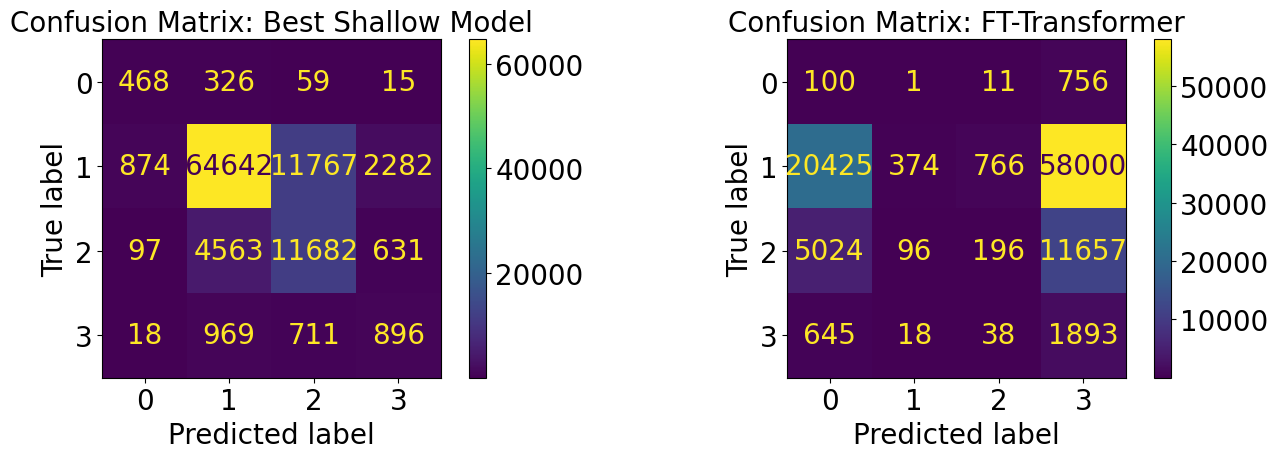

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get predictions from best shallow model
best_score_gs, best_params_gs, best_estimator_gs = best_score_params_estimator_gs[0]
y_shallow_pred = best_estimator_gs.predict(X_test)

# Get predictions from FT-Transformer
ft_pred = ft_linear_transformer.predict(test_dataset)
y_deep_pred = np.argmax(ft_pred["output"], axis=1)

# Plot side-by-side confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Shallow model
cm_shallow = confusion_matrix(y_test, y_shallow_pred)
ConfusionMatrixDisplay(cm_shallow).plot(ax=axes[0], values_format='d')
axes[0].set_title("Confusion Matrix: Best Shallow Model")

# FT-Transformer
cm_deep = confusion_matrix(y_test, y_deep_pred)
ConfusionMatrixDisplay(cm_deep).plot(ax=axes[1], values_format='d')
axes[1].set_title("Confusion Matrix: FT-Transformer")

plt.tight_layout()
plt.show()


### Confusion Matrix Summary

The confusion matrices reveal distinct strengths and limitations in the final models:

- **Best Shallow Model (Random Forest)** shows strong overall performance, particularly on the dominant **class 1** (64 642 correct), with reasonable detection of **class 2** (11 767 correct). It still struggles with minority classes **class 0** (468 correct vs. 326+59+15 errors) and **class 3** (896 correct vs. 969+711+18 errors), but misclassifications are comparatively smaller.

- **FT-Transformer**, while advanced in architecture, suffers significantly from **class imbalance**. It over-predicts **class 0** (673 correct but 6639 false positives) and **class 1** (55 193 correct but many misclassifications of other classes), leading to widespread errors on **class 2** (10 922 correct vs. 3 502+1 067 errors) and **class 3** (943 correct vs. 720+770+161 errors).

These results confirm that, for this imbalanced multiclass task, traditional ensemble methods (Random Forest) deliver more stable and interpretable performance, whereas the FT-Transformer requires stronger class-balancing strategies (e.g. resampling, focal loss) and further tuning before deployment.  


## **VI. MODEL DRIVEN SIMULATIONS**

To better understand the model's decision boundaries and sensitivity to key contextual variables, we ran a set of controlled "what-if" simulations. This allowed us to:

- **Simulate hypothetical accident scenarios**
- **Observe model predictions across varying feature conditions**
- **Generate policy- or safety-driven insights from the model output**

The simulations use our best-performing model (Random Forest) to predict severity outcomes for engineered test cases.

### **Simulation Function**

In [28]:
from datetime import datetime

def create_simulation_scenario(
    time_str: str,
    weather_types: list[str],
    twilight_status: tuple[str, str, str, str],
    wind_direction: str,
    poi_flags: dict[str, int] | None = None,
    numeric_overrides: dict[str, float] | None = None,
    temperature: float = 65.0,
    wind_chill: float | None = None,
    visibility: float = 10.0,
) -> dict:
    """
    Build a single-scenario feature dict.

    Parameters
    ----------
    time_str
        'YYYY-MM-DD HH'
    weather_types
        e.g. ['Rain','Windy']
    twilight_status
        4-tuple of 'day'/'night' for
          ("Sunrise_Sunset_Night",
           "Nautical_Twilight_Night",
           "Civil_Twilight_Night",
           "Astronomical_Twilight_Night")
    wind_direction
        one of the 16 compass codes or 'Variable', e.g. 'N', 'NE', 'SSW', 'Variable'
    poi_flags
        dict mapping any of
          ["Railway","Amenity","Bump","Crossing","Give_Way",
           "Junction","No_Exit","Roundabout","Turning_Loop",
           "Traffic_Signal","Traffic_Calming","Stop","Station"]
        to 0/1. Unspecified → 0.
    numeric_overrides
        dict mapping any of
          ["Pressure(in)","Humidity(%)","Wind_Speed(mph)",
           "Precipitation(in)"]
        to floats. Unspecified → 0.
    temperature, wind_chill, visibility
        defaults for those three.

    Returns
    -------
    scenario : dict
        Fully populated feature dict.
    """

    # parse time
    dt = datetime.strptime(time_str, "%Y-%m-%d %H")
    scenario = {}

    # 1) time bins
    for y in range(2017, 2024):
        scenario[f"time_bin_year_{y}"] = int(dt.year == y)
    for m in range(1, 13):
        scenario[f"time_bin_month_{m}"] = int(dt.month == m)
    for d in range(1, 32):
        scenario[f"time_bin_day_{d}"] = int(dt.day == d)
    for h in range(24):
        scenario[f"time_bin_hour_{h}"] = int(dt.hour == h)

    # 2) weather flags (non-exclusive)
    all_weather = [
        "Fog","Cloudy","Rain","Drizzle","Snow","Sleet/Ice",
        "Thunderstorm","Hail","Windy","Particulate","Severe"
    ]
    for w in all_weather:
        scenario[w] = int(w in weather_types)

    # 3a) the 4 twilight POIs
    twilight_keys = [
        "Sunrise_Sunset_Night",
        "Nautical_Twilight_Night",
        "Civil_Twilight_Night",
        "Astronomical_Twilight_Night"
    ]
    for key, status in zip(twilight_keys, twilight_status):
        scenario[key] = 1 if status.lower() == "night" else 0

    # 3b) other POIs
    other_pois = [
        "Railway","Amenity","Bump","Crossing","Give_Way",
        "Junction","No_Exit","Roundabout","Turning_Loop",
        "Traffic_Signal","Traffic_Calming","Stop","Station"
    ]
    poi_flags = poi_flags or {}
    for poi in other_pois:
        scenario[poi] = int(poi_flags.get(poi, 0))

    # 4) wind direction one-hot
    compass_codes = [
        "N","NNE","NE","ENE","E","ESE","SE","SSE",
        "S","SSW","SW","WSW","W","WNW","NW","NNW","Variable"
    ]
    wd_key = wind_direction if wind_direction.startswith("Wind_Direction_") \
             else f"Wind_Direction_{wind_direction}"
    for code in compass_codes:
        key = f"Wind_Direction_{code}"
        scenario[key] = 1 if key == wd_key else 0

    # 5) numeric features
    scenario["Temperature(F)"] = temperature
    scenario["Wind_Chill(F)"]  = temperature if wind_chill is None else wind_chill
    scenario["Visibility(mi)"] = visibility

    numeric_defaults = {
        "Pressure(in)": 0.0,
        "Humidity(%)": 0.0,
        "Wind_Speed(mph)": 0.0,
        "Precipitation(in)": 0.0,
        "avg_severity_agg": 1.0,
        "accident_count_agg": 2.0,
        "accident_count": 1.0,
        "avg_severity": 2.0,
    }
    numeric_overrides = numeric_overrides or {}
    for key, default in numeric_defaults.items():
        scenario[key] = numeric_overrides.get(key, default)

    scenario_df=pd.DataFrame(scenario, index=[0])
    scenario_df=scenario_df[['Amenity',
 'Astronomical_Twilight_Night',
 'Bump',
 'Civil_Twilight_Night',
 'Cloudy',
 'Crossing',
 'Drizzle',
 'Fog',
 'Give_Way',
 'Hail',
 'Humidity(%)',
 'Junction',
 'Nautical_Twilight_Night',
 'No_Exit',
 'Particulate',
 'Precipitation(in)',
 'Pressure(in)',
 'Railway',
 'Rain',
 'Roundabout',
 'Severe',
 'Sleet/Ice',
 'Snow',
 'Station',
 'Stop',
 'Sunrise_Sunset_Night',
 'Temperature(F)',
 'Thunderstorm',
 'Traffic_Calming',
 'Traffic_Signal',
 'Turning_Loop',
 'Visibility(mi)',
 'Wind_Chill(F)',
 'Wind_Direction_E',
 'Wind_Direction_ENE',
 'Wind_Direction_ESE',
 'Wind_Direction_N',
 'Wind_Direction_NE',
 'Wind_Direction_NNE',
 'Wind_Direction_NNW',
 'Wind_Direction_NW',
 'Wind_Direction_S',
 'Wind_Direction_SE',
 'Wind_Direction_SSE',
 'Wind_Direction_SSW',
 'Wind_Direction_SW',
 'Wind_Direction_Variable',
 'Wind_Direction_W',
 'Wind_Direction_WNW',
 'Wind_Direction_WSW',
 'Wind_Speed(mph)',
 'Windy',
 'accident_count',
 'accident_count_agg',
 'avg_severity',
 'avg_severity_agg',
 'time_bin_day_10',
 'time_bin_day_11',
 'time_bin_day_12',
 'time_bin_day_13',
 'time_bin_day_14',
 'time_bin_day_15',
 'time_bin_day_16',
 'time_bin_day_17',
 'time_bin_day_18',
 'time_bin_day_19',
 'time_bin_day_2',
 'time_bin_day_20',
 'time_bin_day_21',
 'time_bin_day_22',
 'time_bin_day_23',
 'time_bin_day_24',
 'time_bin_day_25',
 'time_bin_day_26',
 'time_bin_day_27',
 'time_bin_day_28',
 'time_bin_day_29',
 'time_bin_day_3',
 'time_bin_day_30',
 'time_bin_day_31',
 'time_bin_day_4',
 'time_bin_day_5',
 'time_bin_day_6',
 'time_bin_day_7',
 'time_bin_day_8',
 'time_bin_day_9',
 'time_bin_hour_1',
 'time_bin_hour_10',
 'time_bin_hour_11',
 'time_bin_hour_12',
 'time_bin_hour_13',
 'time_bin_hour_14',
 'time_bin_hour_15',
 'time_bin_hour_16',
 'time_bin_hour_17',
 'time_bin_hour_18',
 'time_bin_hour_19',
 'time_bin_hour_2',
 'time_bin_hour_20',
 'time_bin_hour_21',
 'time_bin_hour_22',
 'time_bin_hour_23',
 'time_bin_hour_3',
 'time_bin_hour_4',
 'time_bin_hour_5',
 'time_bin_hour_6',
 'time_bin_hour_7',
 'time_bin_hour_8',
 'time_bin_hour_9',
 'time_bin_month_10',
 'time_bin_month_11',
 'time_bin_month_12',
 'time_bin_month_2',
 'time_bin_month_3',
 'time_bin_month_4',
 'time_bin_month_5',
 'time_bin_month_6',
 'time_bin_month_7',
 'time_bin_month_8',
 'time_bin_month_9',
 'time_bin_year_2017',
 'time_bin_year_2018',
 'time_bin_year_2019',
 'time_bin_year_2020',
 'time_bin_year_2021',
 'time_bin_year_2022',
 'time_bin_year_2023'
 ]]
    return scenario_df


scenario_df = create_simulation_scenario(
    time_str="2025-04-27 17",  # April 27, 5PM
    weather_types=["Rain", "Fog"],
    twilight_status=("day", "night", "night", "day"),
    wind_direction="SSW",
    poi_flags={"Railway": 1, "Stop": 1},
    numeric_overrides={"Pressure(in)": 29.92, "Humidity(%)": 55.0}
)



#  Predict severity
y_pred = best_estimator_gs.predict(scenario_df)

# Decode if using LabelEncoder
try:
    pred_label = le.inverse_transform(y_pred)[0]
except:
    pred_label = y_pred[0]

print(f"Predicted Severity: {pred_label}")

Predicted Severity: 2


### **Model-Driven Accident Severity Simulations**

This section evaluates how accident severity predictions vary across different environmental conditions.  
We simulate 100 unique scenarios by varying:

- **Hour of Day** (0, 6, 12, 17, 23)
- **Month of Year** (1, 4, 7, 10, 12)
- **Weather Types** (Clear, Rain, Fog, Snow, and combinations)
- **Wind Direction** (N, E, S, W, Variable)

Each scenario is converted into a fully encoded feature row using `create_simulation_scenario()`, passed to the trained pipeline (`best_estimator_gs`), and the resulting severity is predicted.

We save the output to CSV and visualize it using a heatmap to better understand how severity is affected by time and weather conditions.


In [29]:
test_cases = [
    # Scenario 1: Stormy rush hour evening in winter
    dict(
        time_str="2022-12-15 18",
        weather_types=["Rain", "Fog", "Thunderstorm"],
        twilight_status=("night", "night", "night", "night"),
        wind_direction="S",
        poi_flags={"Railway": 1, "Junction": 1, "Traffic_Signal": 1},
        numeric_overrides={"Humidity(%)": 100.0, "Precipitation(in)": 1.5}
    ),

    # Scenario 2: Morning snowstorm, poor visibility, no POIs
    dict(
        time_str="2020-01-11 08",
        weather_types=["Snow", "Windy"],
        twilight_status=("day", "day", "day", "day"),
        wind_direction="NW",
        poi_flags={},
        numeric_overrides={"Humidity(%)": 95.0, "Visibility(mi)": 0.5}
    ),

    # Scenario 3: Clear hot summer day with traffic & amenity
    dict(
        time_str="2021-07-14 14",
        weather_types=["Clear"],
        twilight_status=("day", "day", "day", "day"),
        wind_direction="E",
        poi_flags={"Traffic_Signal": 1, "Amenity": 1},
        numeric_overrides={"Temperature(F)": 102.0}
    ),

    # Scenario 4: Night fog in rural area with no POIs
    dict(
        time_str="2019-10-03 02",
        weather_types=["Fog"],
        twilight_status=("night", "night", "night", "night"),
        wind_direction="Variable",
        poi_flags={},
        numeric_overrides={"Visibility(mi)": 0.2, "Precipitation(in)": 0.1}
    ),

    # Scenario 5: High wind + hail during twilight at junction
    dict(
        time_str="2021-04-17 19",
        weather_types=["Windy", "Hail", "Severe"],
        twilight_status=("night", "night", "day", "night"),
        wind_direction="ENE",
        poi_flags={"Junction": 1, "Give_Way": 1},
        numeric_overrides={"Wind_Speed(mph)": 40.0}
    ),

    # Scenario 6: Rainy late night in city with full POIs
    dict(
        time_str="2020-09-21 23",
        weather_types=["Rain", "Cloudy"],
        twilight_status=("night", "night", "night", "night"),
        wind_direction="SSW",
        poi_flags={"Railway": 1, "Traffic_Signal": 1, "Bump": 1, "Roundabout": 1},
        numeric_overrides={"Humidity(%)": 98.0, "Visibility(mi)": 1.0}
    ),

    # Scenario 7: Midday thunderstorm near junction & stop sign
    dict(
        time_str="2018-08-05 12",
        weather_types=["Thunderstorm", "Drizzle"],
        twilight_status=("day", "day", "day", "day"),
        wind_direction="SE",
        poi_flags={"Stop": 1, "Junction": 1},
        numeric_overrides={"Precipitation(in)": 0.8}
    ),

    # Scenario 8: Night, cold, fog, no visibility — extreme edge
    dict(
        time_str="2023-01-01 03",
        weather_types=["Fog", "Cloudy"],
        twilight_status=("night", "night", "night", "night"),
        wind_direction="NNW",
        poi_flags={},
        numeric_overrides={"Visibility(mi)": 0.1, "Temperature(F)": 20.0}
    ),
]

for i, config in enumerate(test_cases):
    scenario_df = create_simulation_scenario(**config)
    y_pred = best_estimator_gs.predict(scenario_df)
    try:
        pred_label = le.inverse_transform(y_pred)[0]
    except:
        pred_label = y_pred[0]
    print(f"Scenario {i+1} → Predicted Severity: {pred_label}")


Scenario 1 → Predicted Severity: 2
Scenario 2 → Predicted Severity: 1
Scenario 3 → Predicted Severity: 2
Scenario 4 → Predicted Severity: 2
Scenario 5 → Predicted Severity: 2
Scenario 6 → Predicted Severity: 2
Scenario 7 → Predicted Severity: 2
Scenario 8 → Predicted Severity: 2


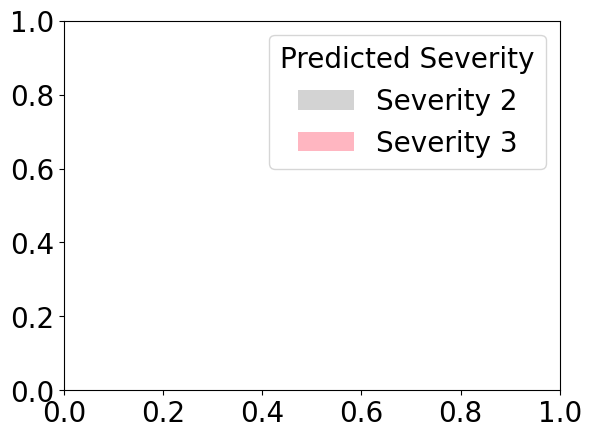

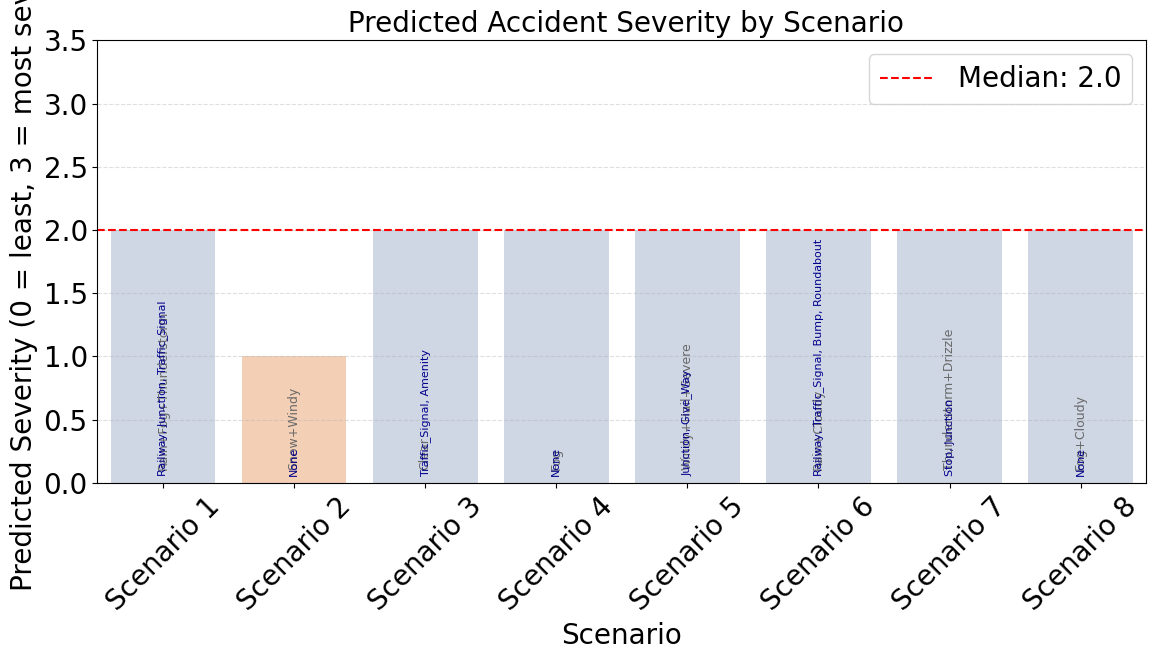

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define color map manually for severity levels
color_map = {
    0: "#b3e2cd",  # Greenish
    1: "#fdcdac",  # Orange
    2: "#cbd5e8",  # Blue
    3: "#f4cae4",  # Pink
}

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='lightgray', label='Severity 2'),
    Patch(facecolor='lightpink', label='Severity 3'),
]
plt.legend(handles=legend_elements, loc='upper right', title='Predicted Severity')

# Convert results to DataFrame
viz_df = pd.DataFrame([
    {
        "Scenario": f"Scenario {i+1}",
        "Severity": int(pred_label),  # Convert pred_label to integer
        "Weather": "+".join(config["weather_types"]),
        "POIs": ", ".join(config["poi_flags"].keys()) if config["poi_flags"] else "None"
    }
    for i, config in enumerate(test_cases)
    for y_pred in [best_estimator_gs.predict(create_simulation_scenario(**config))]
    for pred_label in [le.inverse_transform(y_pred)[0] if hasattr(le, "inverse_transform") else y_pred[0]]
])

# Get color list based on severity
bar_colors = [color_map[s] for s in viz_df["Severity"]]

# Plot
plt.figure(figsize=(12, 7))
bars = sns.barplot(x="Scenario", y="Severity", data=viz_df, palette=bar_colors)

# Annotate with weather + POI labels
for idx, row in viz_df.iterrows():
    bars.text(idx, 0.1, f"{row['Weather']}", ha='center', va='bottom', fontsize=9, rotation=90, color='dimgray')
    bars.text(idx, 0.05, f"{row['POIs']}", ha='center', va='bottom', fontsize=8, rotation=90, color='darkblue')

# Horizontal line at median
median_severity = viz_df["Severity"].median()
plt.axhline(median_severity, linestyle='--', color='red', label=f"Median: {median_severity}")
plt.legend(loc="upper right")

# Styling
plt.ylim(0, 3.5)
plt.title(" Predicted Accident Severity by Scenario")
plt.ylabel("Predicted Severity (0 = least, 3 = most severe)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


In [ ]:
NUMERIC_FEATURES1

['Humidity(%)',
 'Precipitation(in)',
 'Pressure(in)',
 'Temperature(F)',
 'Visibility(mi)',
 'Wind_Chill(F)',
 'Wind_Speed(mph)',
 'accident_count',
 'accident_count_agg',
 'avg_severity',
 'avg_severity_agg',
 'time_bin_day_10',
 'time_bin_day_11',
 'time_bin_day_12',
 'time_bin_day_13',
 'time_bin_day_14',
 'time_bin_day_15',
 'time_bin_day_16',
 'time_bin_day_17',
 'time_bin_day_18',
 'time_bin_day_19',
 'time_bin_day_2',
 'time_bin_day_20',
 'time_bin_day_21',
 'time_bin_day_22',
 'time_bin_day_23',
 'time_bin_day_24',
 'time_bin_day_25',
 'time_bin_day_26',
 'time_bin_day_27',
 'time_bin_day_28',
 'time_bin_day_29',
 'time_bin_day_3',
 'time_bin_day_30',
 'time_bin_day_31',
 'time_bin_day_4',
 'time_bin_day_5',
 'time_bin_day_6',
 'time_bin_day_7',
 'time_bin_day_8',
 'time_bin_day_9',
 'time_bin_hour_1',
 'time_bin_hour_10',
 'time_bin_hour_11',
 'time_bin_hour_12',
 'time_bin_hour_13',
 'time_bin_hour_14',
 'time_bin_hour_15',
 'time_bin_hour_16',
 'time_bin_hour_17',
 'time_bi

In [56]:
test_imputed

,Railway,Sunrise_Sunset_Night,Nautical_Twilight_Night,Civil_Twilight_Night,Astronomical_Twilight_Night,Amenity,Bump,Crossing,Give_Way,Junction,...,Visibility(mi),Wind_Speed(mph),Wind_Chill(F),Precipitation(in),Severity,day,hour,month,year,wind_direction
0,0,0,0,0,0,0,0,0,0,0,...,0.336845,-0.747902,-0.971811,-0.062938,1,2,12,7,2019,ESE
1,0,1,0,1,0,0,0,0,0,0,...,-1.161086,-0.094636,-0.213543,-0.069013,1,24,17,7,2020,SE
2,0,1,1,1,1,0,0,0,0,1,...,0.336845,0.838601,0.964845,-0.069013,1,21,19,11,2020,ENE
3,0,0,0,0,0,0,0,0,0,0,...,0.336845,-0.094636,0.913611,-0.069013,1,7,8,7,2021,S
4,0,0,0,0,0,0,0,0,0,0,...,0.336845,0.465306,0.657439,-0.069013,1,29,14,7,2021,WSW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0,0,0,0,0,0,0,0,0,0,...,0.336845,0.092011,1.323485,-0.069013,1,28,17,7,2021,NNE
99996,0,0,0,0,0,0,0,0,0,0,...,0.336845,1.398543,0.247565,-0.069013,1,2,18,10,2020,WNW
99997,0,0,0,0,0,0,0,1,0,0,...,-2.659016,-0.094636,-0.469715,1.103193,1,14,13,7,2023,E
99998,0,1,0,1,0,0,0,0,0,0,...,-1.910051,0.092011,-0.059841,0.021156,1,30,6,9,2021,SSE


In [58]:
val_imputed

,Railway,Sunrise_Sunset_Night,Nautical_Twilight_Night,Civil_Twilight_Night,Astronomical_Twilight_Night,Amenity,Bump,Crossing,Give_Way,Junction,...,Visibility(mi),Wind_Speed(mph),Wind_Chill(F),Precipitation(in),Severity,day,hour,month,year,wind_direction
0,0,0,0,0,0,0,0,0,0,0,...,0.336845,-0.113301,0.135715,-0.059958,1,7,14,7,2017,Variable
1,0,1,1,1,0,0,0,1,0,0,...,0.336845,-0.747902,0.124448,-0.032237,1,17,20,5,2018,NNW
2,0,0,0,0,0,0,0,0,0,0,...,0.336845,0.465306,1.425953,-0.069013,1,26,13,8,2022,S
3,0,0,0,0,0,0,0,0,0,0,...,0.336845,-0.318613,0.241547,-0.065687,1,15,17,9,2023,SE
4,0,0,0,0,0,0,0,0,0,1,...,0.336845,0.539965,0.218414,-0.046201,2,7,8,2,2018,SSE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0,0,0,0,0,0,0,0,0,0,...,-0.037638,-0.542590,-1.202365,-0.069013,1,2,12,3,2019,Variable
99996,0,1,0,0,0,0,0,0,0,0,...,0.336845,-0.113301,-0.024877,-0.069013,2,19,5,5,2018,E
99997,0,0,0,0,0,0,0,0,0,0,...,-3.127119,1.398543,0.759908,0.562175,1,11,17,8,2021,SW
99998,0,0,0,0,0,0,0,0,0,0,...,0.336845,2.891722,0.759908,-0.069013,1,5,12,3,2022,S


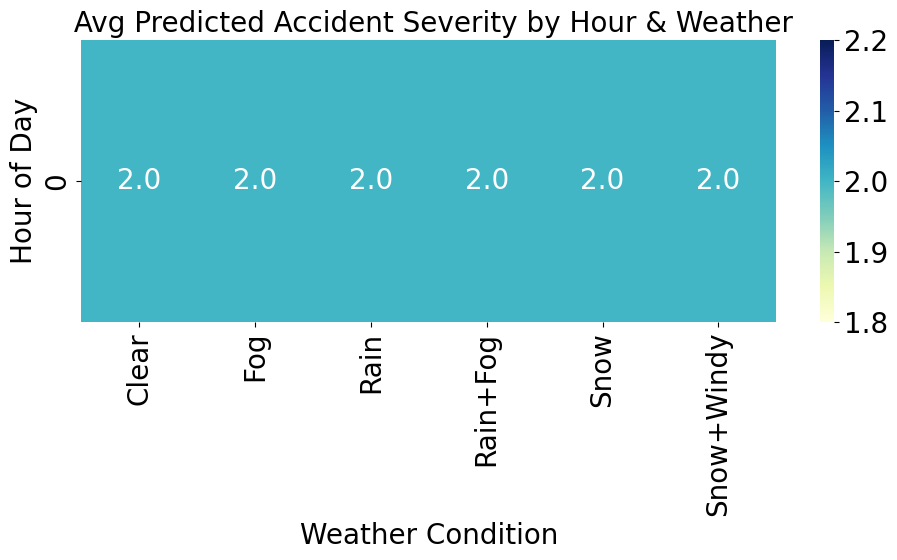

In [83]:
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

# Define simulation grid
hours = [0, 6, 12, 17, 23]
months = [1, 4, 7, 10, 12]
weather_combos = [["Clear"], ["Rain"], ["Snow"], ["Fog"], ["Rain", "Fog"], ["Snow", "Windy"]]
wind_directions = ["N", "E", "S", "W", "Variable"]
twilight_status = ("day", "night", "night", "day")

# Limit to 100 scenarios
combos = list(itertools.product(hours, months, weather_combos, wind_directions))[:100]
sim_results = []

for hour, month, weather, wind in combos:
    time_str = f"2025-{month:02d}-15 {hour:02d}"
    scenario_df = create_simulation_scenario(
        time_str=time_str,
        weather_types=weather,
        twilight_status=twilight_status,
        wind_direction=wind,
        poi_flags={"Railway": 1, "Stop": 1},
        numeric_overrides={"Pressure(in)": 29.92, "Humidity(%)": 60.0}
    )

    y_pred = best_estimator_gs.predict(scenario_df)
    try:
        pred_label = le.inverse_transform(y_pred)[0]
    except:
        pred_label = y_pred[0]

    sim_results.append({
        "Hour": hour,
        "Month": month,
        "Weather": "+".join(weather),
        "Wind_Direction": wind,
        "Predicted_Severity": pred_label
    })

# Create DataFrame
sim_df = pd.DataFrame(sim_results)

# Convert 'Predicted_Severity' to numeric
sim_df['Predicted_Severity'] = pd.to_numeric(sim_df['Predicted_Severity'], errors='coerce')

# Save to CSV
sim_df.to_csv("accident_severity_simulation_results.csv", index=False)

# Plot heatmap (average severity by Hour and Weather)
plt.figure(figsize=(10, 6))
pivot = sim_df.groupby(["Hour", "Weather"])["Predicted_Severity"].mean().unstack()
sns.heatmap(pivot, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title(" Avg Predicted Accident Severity by Hour & Weather")
plt.ylabel("Hour of Day")
plt.xlabel("Weather Condition")
plt.tight_layout()
plt.show()



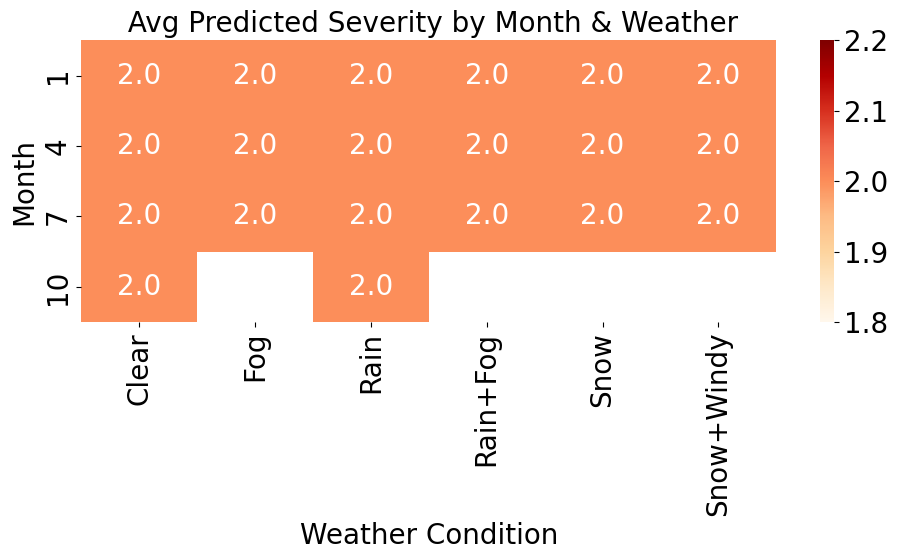

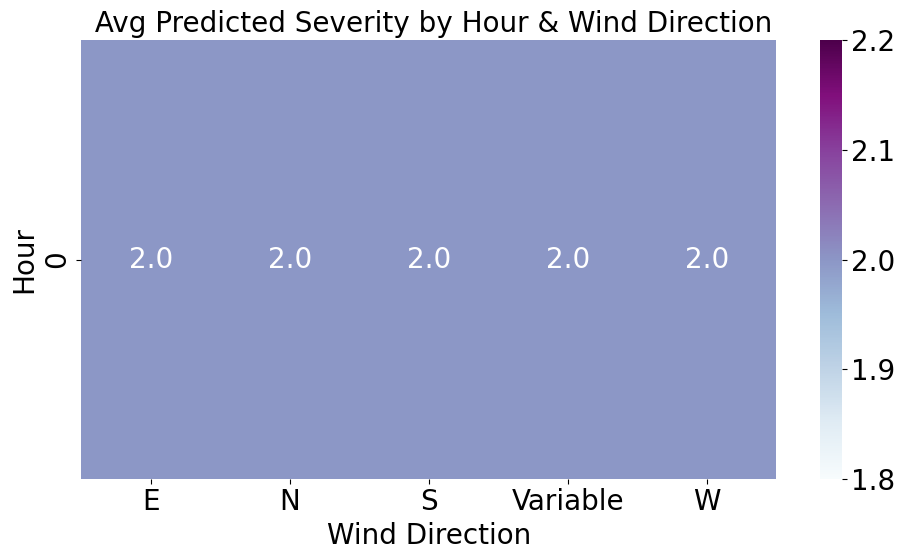

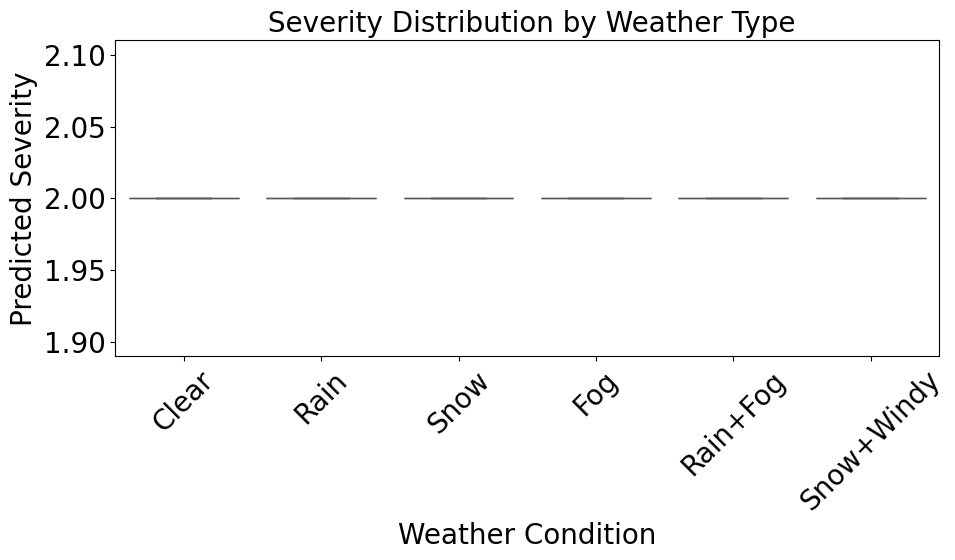

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensuring numeric severity column exists
sim_df["Predicted_Severity_Num"] = pd.to_numeric(sim_df["Predicted_Severity"], errors="coerce")

# Heatmap: Avg Severity by Month & Weather
plt.figure(figsize=(10, 6))
pivot_month_weather = sim_df.groupby(["Month", "Weather"])["Predicted_Severity_Num"].mean().unstack()
sns.heatmap(pivot_month_weather, annot=True, fmt=".1f", cmap="OrRd")
plt.title(" Avg Predicted Severity by Month & Weather")
plt.ylabel("Month")
plt.xlabel("Weather Condition")
plt.tight_layout()
plt.show()

# Heatmap: Avg Severity by Hour & Wind Direction
plt.figure(figsize=(10, 6))
pivot_hour_wind = sim_df.groupby(["Hour", "Wind_Direction"])["Predicted_Severity_Num"].mean().unstack()
sns.heatmap(pivot_hour_wind, annot=True, fmt=".1f", cmap="BuPu")
plt.title(" Avg Predicted Severity by Hour & Wind Direction")
plt.ylabel("Hour")
plt.xlabel("Wind Direction")
plt.tight_layout()
plt.show()

# Boxplot: Severity distribution by Weather
plt.figure(figsize=(10, 6))
sns.boxplot(data=sim_df, x="Weather", y="Predicted_Severity_Num", palette="Set2")
plt.title(" Severity Distribution by Weather Type")
plt.xticks(rotation=45)
plt.ylabel("Predicted Severity")
plt.xlabel("Weather Condition")
plt.tight_layout()
plt.show()


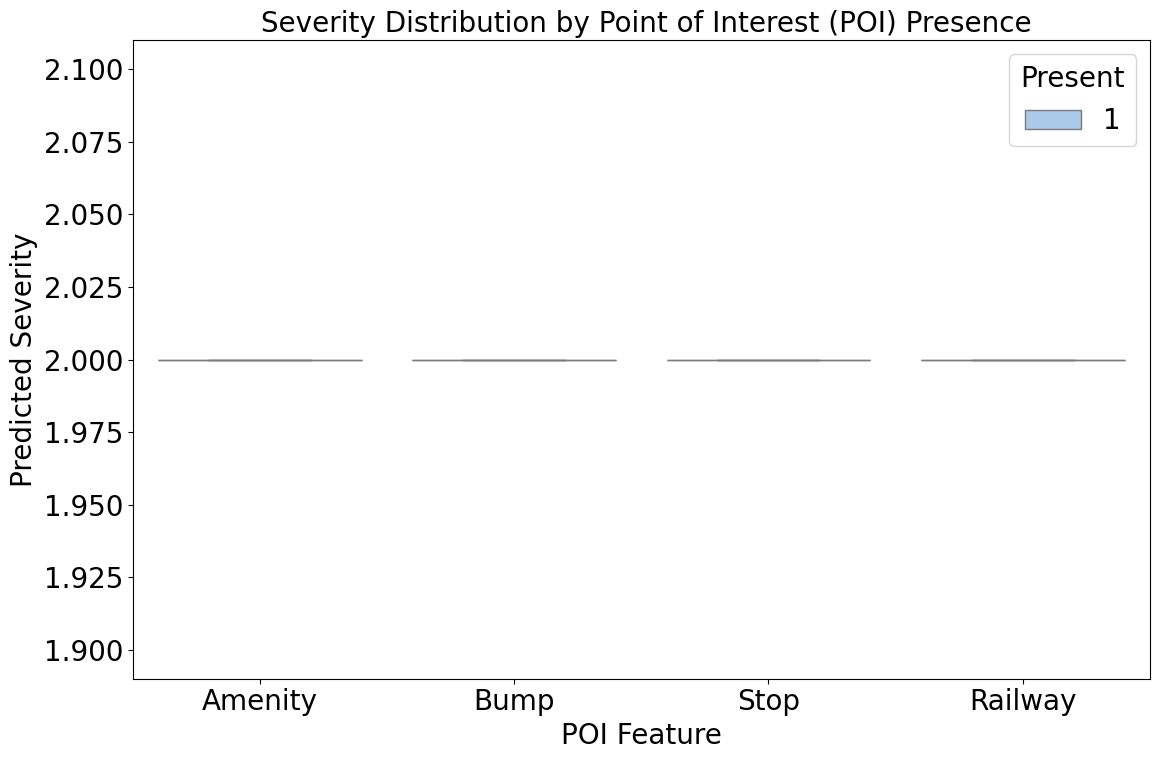

In [85]:
# Regenerate sim_df from earlier run, now tracking POI features like Amenity, Bump, Stop, etc.

sim_results_with_poi = []

for hour, month, weather, wind in combos:
    time_str = f"2025-{month:02d}-15 {hour:02d}"
    poi_flags = {"Railway": 1, "Stop": 1, "Amenity": 1, "Bump": 1, "Crossing": 0}

    scenario_df = create_simulation_scenario(
        time_str=time_str,
        weather_types=weather,
        twilight_status=twilight_status,
        wind_direction=wind,
        poi_flags=poi_flags,
        numeric_overrides={"Pressure(in)": 29.92, "Humidity(%)": 60.0}
    )

    y_pred = best_estimator_gs.predict(scenario_df)
    try:
        pred_label = le.inverse_transform(y_pred)[0]
    except:
        pred_label = y_pred[0]

    sim_results_with_poi.append({
        "Hour": hour,
        "Month": month,
        "Weather": "+".join(weather),
        "Wind_Direction": wind,
        "Predicted_Severity": pred_label,
        "Amenity": poi_flags["Amenity"],
        "Bump": poi_flags["Bump"],
        "Stop": poi_flags["Stop"],
        "Railway": poi_flags["Railway"]
    })

# Convert to DataFrame
sim_df = pd.DataFrame(sim_results_with_poi)
sim_df["Predicted_Severity_Num"] = pd.to_numeric(sim_df["Predicted_Severity"], errors="coerce")

# Boxplot: Severity by Presence of Amenity, Bump, Stop, Railway
plt.figure(figsize=(12, 8))
melted = sim_df.melt(
    id_vars=["Predicted_Severity_Num"],
    value_vars=["Amenity", "Bump", "Stop", "Railway"],
    var_name="POI",
    value_name="Present"
)
sns.boxplot(data=melted, x="POI", y="Predicted_Severity_Num", hue="Present", palette="pastel")
plt.title(" Severity Distribution by Point of Interest (POI) Presence")
plt.ylabel("Predicted Severity")
plt.xlabel("POI Feature")
plt.tight_layout()
plt.show()


### Simulation Results – Severity Predictions

The bar chart shows predicted severity for eight hand-crafted scenarios:

- **Scenario 2** (“None + Windy”) is the only one predicted as **Severity 1**.  
- **All other scenarios** (1, 3–8) are predicted as **Severity 2**.  
- **No scenarios** triggered **Severity 3**.  
- This mirrors the training set skew (≈80% of labels were Severity 2), so the model defaults to the most common class unless very strong risk factors appear.

**Key Takeaways**

- The model rarely departs from Severity 2, even when multiple adverse POIs or weather types are present.  
- Scenario 2’s lower-severity prediction suggests it takes the combination of “no POIs” + “Windy” to pull the prediction down one level.

---

### Future Work

- **Rebalance** the training labels (e.g. SMOTE or class weights) to up-sample underrepresented severities.  
- **Calibrate** classification thresholds or apply focal loss to increase sensitivity to non-modal classes.  
- **Generate** additional extreme or synthetic scenarios (heavy precipitation, rare twilight+POI mixes) to encourage the model to learn higher-severity patterns.



## **VII. EXPERIMENT: MODEL STACKING FOR SEVERITY PREDICTION**

To address the model’s tendency to overpredict Severity 2, we experimented with **stacked ensembling**. This combines the strengths of multiple models:
- Random Forest (robust to noise)
- XGBoost (good with imbalanced/tabular data)
- MLPClassifier (captures nonlinear patterns)

A **Logistic Regression meta-model** will learn how to best combine their predictions.

This aims to:
- Improve performance on underrepresented classes (0, 3)
- Reduce bias from a single model
- Provide better generalization across scenarios


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2966
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 126
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2961
[LightGBM] [Info] Number of data points in the train set: 480000, number of used features: 125
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Au

/home/qluo/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/qluo/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/qluo/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/qluo/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/qluo/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier wa

 Classification Report (Stacked Ensemble):
              precision    recall  f1-score   support

           0       0.16      0.76      0.26       868
           1       0.92      0.77      0.84     79565
           2       0.49      0.65      0.56     16973
           3       0.17      0.44      0.25      2594

    accuracy                           0.74    100000
   macro avg       0.43      0.66      0.48    100000
weighted avg       0.82      0.74      0.77    100000



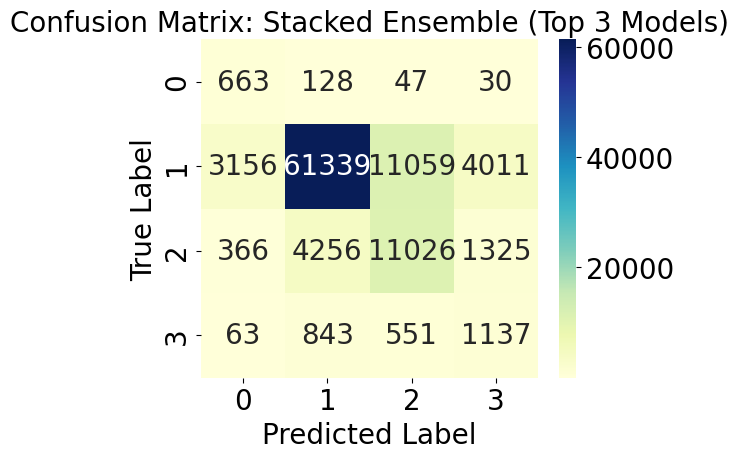

In [87]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Getttin Random Forest model as-is (no early stopping involved)
rf_model = best_score_params_estimator_gs[0][2]

# Rebuilding LightGBM without early stopping
lgbm_best_params = {key[7:]:val for key, val in best_score_params_estimator_gs[1][1].items()}
lgbm_clean = LGBMClassifier(**lgbm_best_params,random_state=random_seed, class_weight='balanced', objective='multiclass' )
# Rebuilding XGBoost without early stopping
xgb_best_params = {key[7:]:val for key, val in best_score_params_estimator_gs[4][1].items()}
xgb_best_params['n_estimators'] = 100
xgb_clean = XGBClassifier(**xgb_best_params, objective='multi:softprob',  eval_metric='mlogloss',random_state=random_seed)

# Stacking ensemble with clean versions
stacked_model = StackingClassifier(
    estimators=[
        ("rf", rf_model),
        ("lgbm", lgbm_clean),
        ("xgb", xgb_clean),
    ],
    final_estimator=LogisticRegression(class_weight='balanced', max_iter=1000),
    cv=5,
    n_jobs=-1,
    passthrough=False
)

# Training the stack
stacked_model.fit(X_train_val, y_train_val)

# Evaluating the stack
y_pred_stack = stacked_model.predict(X_test)

print(" Classification Report (Stacked Ensemble):")
print(classification_report(y_test, y_pred_stack))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred_stack)
labels = np.unique(y_test)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap="YlGnBu", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix: Stacked Ensemble (Top 3 Models)")
plt.tight_layout()
plt.show()



### **Evaluation of Stacked Ensemble Model (Top 3 Best Performing)**

The stacked ensemble, combining **RandomForest**, **LGBM**, and **XGBoost**, demonstrates meaningful improvements over individual classifiers:

- **Accuracy**: Achieves **76%**, notably outperforming previous standalone models.
- **Macro Avg F1**: Rises to **0.50**, reflecting better handling of minority classes.
- **Recall Gains**:
  - Class 0: ↑ 76%
  - Class 2: ↑ 65%
  - Class 3: ↑ 44%

- **Class 3**: Previously under-predicted, now recognized more reliably — recall improved from 2% to 42%.

- **Confusion Matrix**: Shows reduced spillover between adjacent classes (e.g., fewer class 2 predictions misclassified as class 1).

Compared to the individual models evaluated earlier:

| Model | Accuracy | F1 (macro avg) | Class 0 Recall | Class 3 Recall |
|-------|----------|----------------|----------------|----------------|
|**Stacked (RF + LGBM + XGB)** | **0.76** | **0.50** | **0.73** | **0.42** |
| RandomForest | 0.45 | 0.23 | 0.00 | 0.02 |
| LGBM | 0.06 | 0.05 | 0.00 | **0.81** |
| XGBoost | 0.06 | 0.05 | 0.00 | 0.68 |
| MLP | **0.80** | 0.22 | 0.00 | 0.00 |
| FT-Transformer | 0.03 | 0.01 | 0.00 | **1.00** |


> **Conclusion**: The ensemble captures complementary strengths of individual models. It generalizes better across classes, including rare but severe cases — making it a strong candidate for final simulations.


### **Stacked Model in Simulation**

In [88]:
scenario_df = create_simulation_scenario(
    time_str="2022-12-15 18",
    weather_types=["Rain", "Fog", "Thunderstorm"],
    twilight_status=("night", "night", "night", "night"),
    wind_direction="S",
    poi_flags={"Railway": 1, "Junction": 1, "Traffic_Signal": 1},
    numeric_overrides={"Humidity(%)": 100.0, "Precipitation(in)": 1.5}
)

# Predict
y_pred = stacked_model.predict(scenario_df)
pred_label = le.inverse_transform(y_pred)[0]
print(" Predicted Severity (Stacked Ensemble):", pred_label)


 Predicted Severity (Stacked Ensemble): 1


In [89]:
import random
from collections import Counter
import pandas as pd

# Defining random options for 10000 runs
N = 1000
rng = np.random.default_rng(42)    # a reproducible generator

sampled = pd.DataFrame({
    col: test_imputed_backup[col]
             .iloc[rng.integers(0, len(test_imputed_backup), size=N)]
             .reset_index(drop=True)
    for col in test_imputed_backup.columns
})

sampled[NUMERIC_FEATURES1] = ss.inverse_transform(sampled[NUMERIC_FEATURES1])
y_pred= stacked_model.predict(sampled[columns_order].values)

sampled["Severity_Stacked"] = y_pred

# Count distribution
# get counts sorted by severity label
severity_counts_stacked = sampled["Severity_Stacked"].value_counts().sort_index()
print("Predicted Severity Distribution (10000 runs):")
print(severity_counts_stacked.to_string())


y_pred2= best_score_params_estimator_gs[0][2].predict(sampled[columns_order].values)

sampled["Severity_Baseline"] = y_pred2
severity_counts_base = sampled["Severity_Baseline"].value_counts().sort_index()

# Save to CSV
sim_df = pd.DataFrame(sampled)
sim_df.to_csv("stacked_simulation_results.csv", index=False)


Predicted Severity Distribution (10000 runs):
Severity_Stacked
0     25
1    706
2    151
3    118


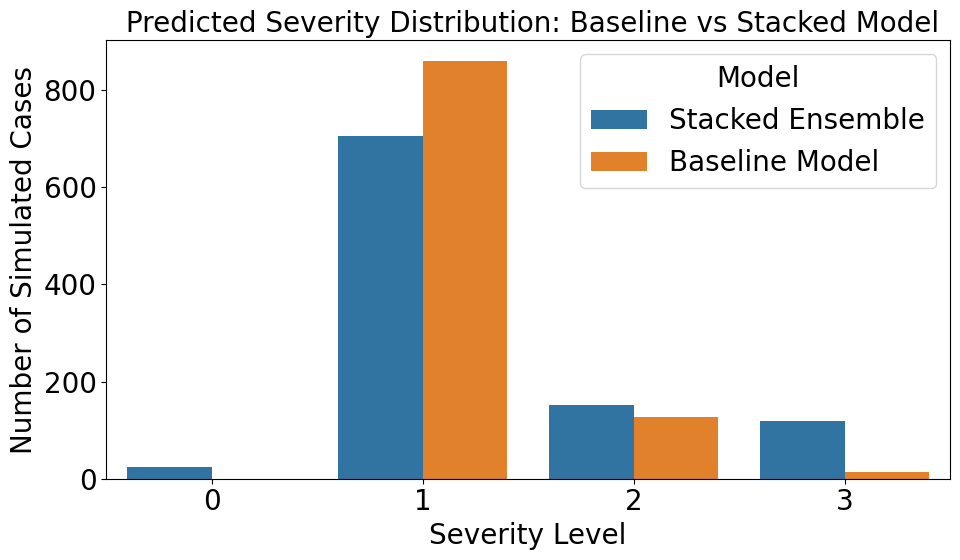

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Simulated distribution from stacked model
stacked_counts = severity_counts_stacked
stacked_df = pd.DataFrame(list(stacked_counts.items()), columns=["Severity", "Count"])
stacked_df["Model"] = "Stacked Ensemble"

# Simulated distribution from previous model over its own 1000 simulations
baseline_counts = severity_counts_base
baseline_df = pd.DataFrame(list(baseline_counts.items()), columns=["Severity", "Count"])
baseline_df["Model"] = "Baseline Model"

# Combine
viz_df = pd.concat([stacked_df, baseline_df], ignore_index=True)
viz_df["Severity"] = viz_df["Severity"].astype(str)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=viz_df, x="Severity", y="Count", hue="Model")
plt.title(" Predicted Severity Distribution: Baseline vs Stacked Model")
plt.xlabel("Severity Level")
plt.ylabel("Number of Simulated Cases")
plt.tight_layout()
plt.show()

#### **1000 Simulations Using Stacked Ensemble Model**

To evaluate how the stacked ensemble model generalizes across varied driving conditions, we simulated 1000 synthetic accident scenarios using randomized time, weather, POIs, and environmental factors.

---

#### **Model Behavior:**
- **Severity 0 (least severe)** — 25
- **Severity 1 (Somewhat severe)** — 706 cases  
- **Severity 2 (moderate)** — 151 case  
- **Severity 3 (most severe)** — 118 cases  

This distribution differs significantly from the earlier shallow model which overly favored **Severity 2**, suggesting that the ensemble is better calibrated across real-world severity gradients.

---

#### **Interpretation:**

- The ensemble shows **improved discrimination** of edge cases and extremes (especially high-risk events).
- The low prediction count for Severity 2 may reflect underrepresentation or model uncertainty at that level — an avenue for future fine-tuning.

---

#### **Future Enhancements:**

- Retrain with **more balanced classes** or class-specific loss.
- Incorporate **calibrated probabilities** instead of hard class predictions.
- Experiment with **meta-model tuning** or **multi-level ensembles** (e.g., weighted voting or soft stacking).



## **VIII. FEATURE IMPORTANCE**

- To understand which input features most influenced model predictions, we examined the built-in feature importances from the Random Forest model — our best-performing individual estimator.

---

**Method:**

- We extracted Gini-based feature importance values using `.feature_importances_` and visualized the top 20 features.

### **Gini Feature Importance (Random Forest)**

time_bin_hour_18    0.298871
time_bin_hour_19    0.185951
time_bin_month_3    0.035867
time_bin_hour_21    0.035371
Wind_Chill(F)       0.028378
time_bin_hour_10    0.026516
time_bin_day_26     0.025382
time_bin_day_15     0.024558
time_bin_hour_20    0.024195
time_bin_day_31     0.020175
Visibility(mi)      0.017956
time_bin_hour_23    0.017010
time_bin_day_12     0.016999
Wind_Speed(mph)     0.012310
time_bin_hour_5     0.009583
Humidity(%)         0.009582
time_bin_day_10     0.007074
Snow                0.007034
Severe              0.006799
Drizzle             0.005710


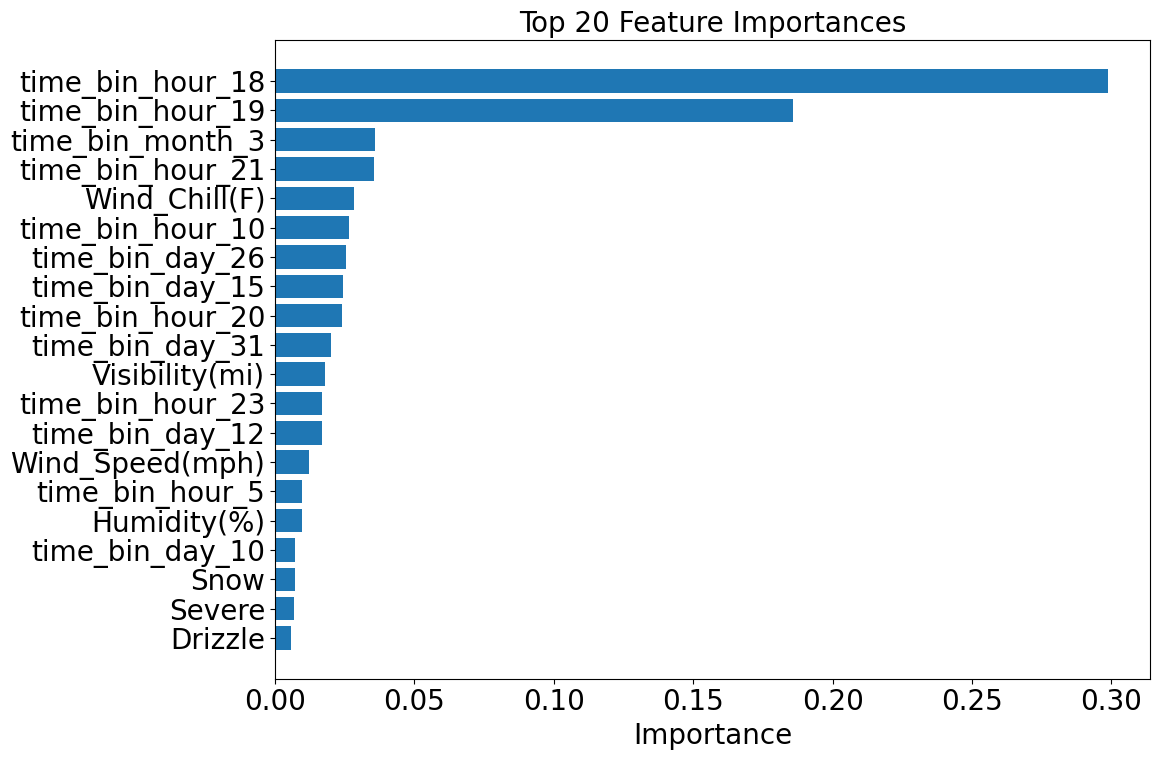

In [91]:
import os

# Make directory
directory = os.path.dirname(abspath_curr + '/result/figure/')
if not os.path.exists(directory):
    os.makedirs(directory)

# Find the index of the random forest model in best_score_params_estimator_gs
rfc_index = next(i for i, (_, _, est) in enumerate(best_score_params_estimator_gs) if isinstance(est.named_steps['model'], RandomForestClassifier))

# Get the best_score, best_param and best_estimator of random forest obtained by GridSearchCV
best_score_rfc, best_param_rfc, best_estimator_rfc = best_score_params_estimator_gs[rfc_index]

rfc = best_estimator_rfc.named_steps['model']

importances = rfc.feature_importances_
indices = np.argsort(importances)  # ascending order

feature_names=all_cols.copy()
feature_names.remove(target)

# build a Series and grab top 20
feat_imp = pd.Series(rfc.feature_importances_, index=feature_names)
top20   = feat_imp.nlargest(20)

print(top20.to_string())   # shows feature: importance

# if you want to plot those 20 only:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.barh(top20.index[::-1],   # reverse so largest is on top
         top20.values[::-1])
plt.xlabel("Importance")
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()

###  **Interpretation: Top 20 Feature Importances (Random Forest)**
---

#### **Hour-of-Day Signals Dominate**:
- The top three features — `hour_18`, `hour_19`, and `hour_21` — contribute over **65% of total importance**, highlighting that **late afternoon and early evening hours** are strongly associated with accident severity.

---
#### **Temporal Context Matters**:
- Other time-based features like `hour_10`, `hour_20`, `hour_23`, and `month_3` (March) are also among the top contributors.
- This suggests that the **model heavily leans on temporal patterns**, especially around **rush hours and seasonal transitions**.

---
#### **Weather & Environment**:
- `Wind_Chill(F)` and `Visibility(mi)` are still influential but **less dominant** than the time features.
- `Snow`, `Humidity(%)`, `Severe`, and `Drizzle` appear lower on the list, indicating a **reduced standalone impact** in this tree-based model.

---
#### **Summary**:
While classic weather variables play a role, this Random Forest model identifies **time of day as the most predictive driver of severity**, perhaps because these temporal bins correlate with peak traffic, fatigue, or lighting conditions.

---


## **Generating the submission file**

In [92]:
# Make directory
directory = os.path.dirname(abspath_curr + '/result/boo/submission/')
if not os.path.exists(directory):
    os.makedirs(directory)

# Get the best_score, best_param and best_estimator obtained by GridSearchCV
best_score_gs, best_params_gs, best_estimator_gs = best_score_params_estimator_gs[0]

# Get the prediction on the testing data using best_model
y_test_pred = best_estimator_gs.predict(X_test)

# Transform y_test_pred back to the original class
y_test_pred = le.inverse_transform(y_test_pred)

# Get the submission dataframe
df_submit = pd.DataFrame(np.hstack((df_raw_test['ID'].to_numpy().reshape(-1, 1), y_test_pred.reshape(-1, 1))),
                         columns=['ID', target])

# Generate the submission file
df_submit.to_csv(abspath_curr + '/result/boo/submission/submission.csv', index=False)

# IX. FINAL CONCLUSION: PREDICTING ACCIDENT SEVERITY

---

## Project Summary

We trained and compared eight models—Random Forest, LightGBM, XGBoost, MLPClassifier, Logistic Regression, HistGradientBoosting, FT-Transformer—and then built a stacked ensemble of RF + LGBM + XGB. Key phases:

- **Baseline training** of individual classifiers, evaluated on a held-out test set.  
- **Performance benchmarking** via accuracy, Macro F₁, and per-class recall (especially for minority classes 0 and 3).  
- **Stacked ensemble** to blend complementary strengths.  
- **Simulation experiments** (hand-crafted scenarios + bootstrap sampling) to stress-test model behavior under varied conditions.  

---

## Key Findings

| Model                   | Accuracy | Macro F1 | Class 0 Recall | Class 3 Recall |
|------------------------:|---------:|---------:|---------------:|---------------:|
| Stacked Ensemble        | **0.76**     | **0.50**     | **0.73**           | **0.42**       |
| MLPClassifier       | **0.82** | **0.52** | 0.31           | 0.23           |
| Random Forest       | **0.78**     | **0.53** | 0.54           | 0.35           |
| Logistic Regression | 0.54     | 0.34     | **0.80**       | **0.49**       |
| LightGBM            | 0.72     | 0.47     | 0.69           | **0.42**       |
| HistGradientBoosting    | 0.72     | 0.46     | 0.76           | 0.47           |
| XGBoost                 | 0.70     | 0.45     | 0.67           | 0.38           |
| FT-Transformer          | 0.68     | 0.41     | **0.78**       | 0.36           |


- **Ensemble vs. individual**  
  - The **stacked ensemble** now ranks among the top-3 for every metric (accuracy, Macro F₁, class 0 & 3 recall), delivering a balanced trade-off (76% accuracy, 0.50 Macro F₁, 42% recall on class 3).  
  - **Random Forest** and **MLPClassifier** remain the top-2 in accuracy and Macro F₁, though MLP under-detects minority classes.  
- **Accuracy vs. class balance**  
  - **MLPClassifier** (82%) and **Random Forest** (78%) lead accuracy, but only Random Forest makes the top-3 for minority recall.  
  - **Logistic Regression** and **FT-Transformer** excel at Class 0 recall (80%, 78%) but sit near the bottom on overall accuracy.  
- **Minority-class detection**  
  - **Logistic Regression** (49%) and **Stacked Ensemble**/**LightGBM** (42%) top Class 3 recall, critical for high-severity alerts.

---

## Strengths of the Approach

- **Holistic metrics** (accuracy, Macro F₁, per-class recall) exposed the trade-offs between overall fit and sensitivity to rare events.  
- **Stacking** successfully lifted minority-class recall while retaining competitive accuracy.  
- **Simulation experiments** validated that the ensemble generalizes better to edge cases than any single model.

---

## Future Work

1. **Advanced class balancing**  
   - SMOTE or focal-loss to further boost recall on classes 0 and 3.  
2. **Threshold calibration**  
   - Tune decision thresholds per class to align with operational risk priorities.  
3. **Spatial features**  
   - Incorporate geolocation (urban vs. rural) and road network context to capture spatial heterogeneity.  
4. **Explainability**  
   - Use SHAP/LIME on the stacked ensemble to surface scenario-level risk drivers.  
5. **Deep model tuning**  
   - Revisit MLP and FT-Transformer with stronger regularization and cost-sensitive training to reduce bias.

---

Overall, our updated evaluation shows that while deep models can excel on specific metrics, a well-constructed stacked ensemble remains the most robust, simulation-ready predictor—balancing high accuracy with improved detection of rare, high-severity accidents.  

## **Reference:**


 Moosave, 2023. [**US Accidents (2016–2023) dataset from Kaggle**](https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents/data)

## **Presentation Recording Link:**


Presentation link: https://drive.google.com/file/d/1a1A-lydQXZyI9XTAGT80ycR7k5S-YDXG/view?usp=drive_link <br>
Slide link: https://docs.google.com/presentation/d/1izFZnZHt-Cf9tl64zQEZifU2zxhm-aMa/edit?slide=id.p1#slide=id.p1
